In [ ]:
# exploring clinical variables

In [7]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [8]:
#establishing a connection to Dr. Luo's mimic database server, remember to connect to nu vpn first.

import psycopg2
# conn = psycopg2.connect(dbname="mimic", user="student", password="lipup", host="luolabwkstn01.fsm.northwestern.edu", port="5432")
# cur=conn.cursor()

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 5.65 s


In [9]:
#input the sql_exe_show object and get dataframe for only patients in patient list out. 
def sql_exe_show(sql_sentence):
    cur.execute(sql_sentence)
    rows = cur.fetchall()
    col = []
    for i in range(len(cur.description)):
        col.append(cur.description[i][0])
    table = pd.DataFrame(rows,columns=col)
    return table

def sql_to_df_icu(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['icustay_id'].isin(icustay_id)]
    return sql_exe_show_df

def sql_to_df_patients(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['subject_id'].isin(patients)]
    return sql_exe_show_df

def sql_to_df_hadm(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['hadm_id'].isin(hadm_id)]
    return sql_exe_show_df

def clinvar_fxn(var_name, path):
    f= open(path, 'r')
    var = f.read()
    cur.execute('rollback')
    cur.execute(var)
    try:
        df= sql_to_df_icu(sql_exe_show('select * from %s;' %(var_name)))
    except KeyError or NameError:
        try:      
            df= sql_to_df_hadm(sql_exe_show('select * from %s;' %(var_name)))
        except KeyError or NameError:
            df= sql_to_df_patients(sql_exe_show('select * from %s;' %(var_name)))

    print(df.shape)
    return(df)



time: 47.9 ms


In [4]:
import os
cwd= os.getcwd()

time: 1.07 ms


In [3]:
cwd

'/Users/geickelb1'

time: 3.28 ms


In [13]:
#importing clinical variable csv
#lab = f'data/interim/{today}-winemag_priceGBP.csv'

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/notebooks
final_pt_df2 = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/16082018_final_pt_df2.csv', index_col=0)
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

#vaso_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/10072018_vaso_all_df.csv', index_col=0)

# labs_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
# labs_all48= labs_all48[labs_all48['label'].notnull()] #labs_all48 has some rows with null label... this removes them.
# bg_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
# vital_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/vital_all48_df.csv', index_col=0)

#08/06/2018
ventsettings_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/15082018_ventsettings_df.csv', index_col=0)
urine_output_all_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/03082018_urine_output_all_df.csv', index_col=0)
labs_all_nosummary_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/03082018_labs_all_nosummary_df.csv', index_col=0)

#8/24/18
bg_all_nosummary_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/24082018_bg_all_nosummary_df.csv', index_col=0)



/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 7.22 s


In [6]:
ventsettings_all2_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/temp/06082018_ventsettings_all2_df.csv', index_col=0)


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 4.83 s


# notes: 08/06/18
trying to iron out all of the necessary ventillation variables. In summary, the vent variables we need that are present in the laboratory items table are not as comprehensive as those found w/ the other ventilator data. trying to identify the varibles of interest, and parsing through the vent_settings.sql from mimic to see what we need.


In [21]:
# date= '06082018'
# pd.DataFrame(sleep_vent_types_df['label'].unique()).to_csv(
#     '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/temp/%s_uti_labs_test_types_df.csv' %(date))

time: 8.13 ms


In [45]:
# date= '06082018'
# pd.DataFrame(ventsettings_all2_df).to_csv(
#     '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/temp/%s_ventsettings_all2_df.csv' %(date))

time: 23.6 s


####setting up for questions with Nelson and Yuan:

In [307]:
#ventsettings_df[list(ventsettings_df.columns)[2:]] #688532 rows
#12656 unique icustay_id's. out of total possible 12801
#each icustay_id has many rows, so a icustay_id can have many different types of ventilation.
ventsettings_df.sort_values(['icustay_id','charttime']).head(20)

#extubated: planned extubated (removed ventilation tube)
#selfextubated: unplanned pt removal of breathing tube

,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
202732,200012.0,2153-12-23 06:15:00,0,1,0,0
1116063,200012.0,2153-12-23 07:45:00,0,1,0,0
2158830,200012.0,2153-12-23 12:00:00,0,1,0,0
2346939,200012.0,2153-12-23 15:00:00,0,1,0,0
1796285,200014.0,2105-02-16 23:15:00,1,0,0,0
2111778,200014.0,2105-02-17 02:00:00,1,0,0,0
938597,200014.0,2105-02-17 04:00:00,1,0,0,0
1570359,200014.0,2105-02-17 09:20:00,1,0,0,0
1781240,200014.0,2105-02-17 14:30:00,1,0,0,0
1705686,200014.0,2105-02-17 16:00:00,1,0,0,0


time: 1.97 s


# 8/15/18 todo:

need to categorize each pt 24 hour window after t_0 into 3 categories:
- Vent- had mech vent within 24hr period
- Oxygen- had only oxygentherapy within 24hr period
- None- had neither within 24hr period.

only care about first 72 hours. so need to make 3 input variables: vent day 1, vent day2, vent day 3. 

switching gears, with sofa score, we shoudl extract 24hr sofa score for each day from t_0 all the way to discharge, death or day 28. this can be used downstream

In [14]:
#

def vent_categorization(final_pt_df2, ventsettings_df):
    """
    overview: provides 3 variables, one for each 24 hour peroid following first ab administration, that codes vent status during that 24 hr peroid.
    ventilation data is based upon the ventsettings.sql file output. 
       categories: 
        - Vent- had mech vent within 24hr period
        - Oxygen- had only oxygentherapy within 24hr period
        - None- had neither within 24hr period.
        - Not_coded= data was not present
        
    input: final cohort dataframe (by icustay_id/hadm_id) annotated with t_0
    output: a dataframe with every icustay_id as a row, and a categorization for each of the first 3 days based on ventilation recieved:
    """
    
    ventsettings_merge_df= pd.merge(ventsettings_df,
                                final_pt_df2[['icustay_id','t_0']],
                                left_on='icustay_id',
                                right_on= 'icustay_id',
                                how='left')
 
    ventsettings_df_3dayannotation= final_pt_df2[['icustay_id','t_0']]
    
    #origionally coded as: Not_coded as the default. changed to none at Nelson's request
    ventsettings_df_3dayannotation['vent_day1']='None' #coding Not_coded as the default. must be sure to code over this to None to ensure I capture everyone
    ventsettings_df_3dayannotation['vent_day2']='None' #coding Not_coded as the default. must be sure to code over this to None to ensure I capture everyone
    ventsettings_df_3dayannotation['vent_day3']='None' #coding Not_coded as the default. must be sure to code over this to None to ensure I capture everyone
    ventsettings_df_3dayannotation.head()

    day1= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('00:00:00','23:59:59'))
    day2= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('24:00:00','47:59:59'))
    day3= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('48:00:00','71:59:59'))

    mech_1= list(ventsettings_merge_df.loc[day1 & ventsettings_merge_df['mechvent']==1 ,'icustay_id'])
    mech_2= list(ventsettings_merge_df.loc[day2 & ventsettings_merge_df['mechvent']==1 ,'icustay_id'])
    mech_3= list(ventsettings_merge_df.loc[day3 & ventsettings_merge_df['mechvent']==1 ,'icustay_id'])
    O2_1= list(ventsettings_merge_df.loc[day1 & ventsettings_merge_df['oxygentherapy']==1 ,'icustay_id'])
    O2_2= list(ventsettings_merge_df.loc[day2 & ventsettings_merge_df['oxygentherapy']==1 ,'icustay_id'])
    O2_3= list(ventsettings_merge_df.loc[day3 & ventsettings_merge_df['oxygentherapy']==1 ,'icustay_id'])
    None_1= list(ventsettings_merge_df[(day1) & (ventsettings_merge_df['mechvent']==0) & (ventsettings_merge_df['oxygentherapy']==0) ]['icustay_id'])
    None_2= list(ventsettings_merge_df[(day2) & (ventsettings_merge_df['mechvent']==0) & (ventsettings_merge_df['oxygentherapy']==0) ]['icustay_id'])
    None_3= list(ventsettings_merge_df[(day3) & (ventsettings_merge_df['mechvent']==0) & (ventsettings_merge_df['oxygentherapy']==0) ]['icustay_id'])

    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(mech_1),'vent_day1']='Mech'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(mech_2),'vent_day2']='Mech'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(mech_3),'vent_day3']='Mech'

    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(O2_1),'vent_day1']='Oxygen'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(O2_2),'vent_day2']='Oxygen'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(O2_3),'vent_day3']='Oxygen'

    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(None_1),'vent_day1']='None'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(None_2),'vent_day2']='None'
    ventsettings_df_3dayannotation.loc[ventsettings_df_3dayannotation.loc[:,'icustay_id'].isin(None_3),'vent_day3']='None'

    return(ventsettings_df_3dayannotation)


time: 94.1 ms


In [15]:
ventcategory_df = vent_categorization(final_pt_df2, ventsettings_df)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

time: 2.06 s


In [141]:
ventcategory_df.head()

,icustay_id,t_0,vent_day1,vent_day2,vent_day3
0,267059.0,2182-11-12,Mech,None,None
1,278729.0,2159-11-08,Oxygen,Mech,None
2,219670.0,2190-08-01,Oxygen,None,None
3,295185.0,2154-11-11,Oxygen,None,None
4,211472.0,2193-12-11,None,None,None


time: 8.1 ms


In [16]:
#the following code is an alternative method to vent_categorization fxn written above. the output gives the # of vent events in a given timeframe
#for each icustay_id
def vent_count(final_pt_df2,ventsettings_df):
    """
    overview: provides 3 variables, one for each 24 hour peroid following first ab administration, that codes vent status during that 24 hr peroid.
    ventilation data is based upon the ventsettings.sql file output. 
       categories: 
        - Vent- had mech vent within 24hr period
        - Oxygen- had only oxygentherapy within 24hr period
        - None- had neither within 24hr period.
        - Not_coded= data was not present
        
    input: final cohort dataframe (by icustay_id/hadm_id) annotated with t_0
    output: a dataframe with every icustay_id as a row, and a categorization for each of the first 3 days based on ventilation recieved:
    """
    ventsettings_merge_df= pd.merge(ventsettings_df,
                                    final_pt_df2[['icustay_id','t_0']],
                                    left_on='icustay_id',
                                    right_on= 'icustay_id',
                                    how='left')

    day1= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('00:00:00','23:59:59'))
    day2= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('24:00:00','47:59:59'))
    day3= (
        (pd.to_datetime(ventsettings_merge_df['t_0'])-pd.to_datetime(ventsettings_merge_df['charttime']))
           .between('48:00:00','71:59:59'))


    #0-1
    icu_O2count1= (
        ventsettings_merge_df.loc[day1 & ventsettings_merge_df['oxygentherapy']==1 ,:]
                  .groupby('icustay_id')['oxygentherapy']
                  .value_counts())
    icu_mechcount1= (
        ventsettings_merge_df.loc[day1 & ventsettings_merge_df['mechvent']==1 ,:]
                .groupby('icustay_id')['mechvent']
                .value_counts())

    #1-2
    icu_O2count2= (
        ventsettings_merge_df.loc[day2 & ventsettings_merge_df['oxygentherapy']==1 ,:]
                  .groupby('icustay_id')['oxygentherapy']
                  .value_counts())

    icu_mechcount2= (
        ventsettings_merge_df.loc[day2 & ventsettings_merge_df['mechvent']==1 ,:]
                .groupby('icustay_id')['mechvent']
                .value_counts())

    #2-3
    icu_O2count3= (
        ventsettings_merge_df.loc[day3 & ventsettings_merge_df['oxygentherapy']==1 ,:]
                  .groupby('icustay_id')['oxygentherapy']
                  .value_counts())

    icu_mechcount3= (
        ventsettings_merge_df.loc[day3 & ventsettings_merge_df['mechvent']==1 ,:]
                .groupby('icustay_id')['mechvent']
                .value_counts())

    #0-1
    icu_O2count_df1= pd.DataFrame(icu_O2count1)
    icu_O2count_df1.columns = ['O2_count1']
    icu_O2count_df1= icu_O2count_df1.reset_index()

    icu_mechcount_df1= pd.DataFrame(icu_mechcount1)
    icu_mechcount_df1.columns = ['mech_count1']
    icu_mechcount_df1= icu_mechcount_df1.reset_index()

    #1-2
    icu_O2count_df2= pd.DataFrame(icu_O2count2)
    icu_O2count_df2.columns = ['O2_count2']
    icu_O2count_df2= icu_O2count_df2.reset_index()

    icu_mechcount_df2= pd.DataFrame(icu_mechcount2)
    icu_mechcount_df2.columns = ['mech_count2']
    icu_mechcount_df2= icu_mechcount_df2.reset_index()

    #2-3
    icu_O2count_df3= pd.DataFrame(icu_O2count3)
    icu_O2count_df3.columns = ['O2_count_3']
    icu_O2count_df3= icu_O2count_df3.reset_index()

    icu_mechcount_df3= pd.DataFrame(icu_mechcount3)
    icu_mechcount_df3.columns = ['mech_count_3']
    icu_mechcount_df3= icu_mechcount_df3.reset_index()

    #merging all together
    icu_vent_status= pd.merge(icu_O2count_df1,icu_O2count_df2, how='outer')
    icu_vent_status= pd.merge(icu_vent_status,icu_O2count_df3,  how='outer')
    icu_vent_status= pd.merge(icu_vent_status,icu_mechcount_df1,  how='outer')
    icu_vent_status= pd.merge(icu_vent_status,icu_mechcount_df2,  how='outer')
    icu_vent_status= pd.merge(icu_vent_status,icu_mechcount_df3,  how='outer')
    
    return(icu_vent_status.drop(['oxygentherapy','mechvent'], axis=1))

time: 163 ms


In [17]:
vent_count_df= vent_count(final_pt_df2,ventsettings_df)

time: 1.67 s


In [18]:
ventcategory_df.describe()

,icustay_id
count,15207.000000
mean,249857.452818
std,28913.425698
min,200012.000000
25%,224532.000000
50%,250064.000000
75%,274783.500000
max,299995.000000


time: 22.8 ms


In [136]:
vent_count_df.describe()

,icustay_id,O2_count1,O2_count2,O2_count_3,mech_count1,mech_count2,mech_count_3
count,8943.000000,5430.000000,1127.000000,590.000000,4001.000000,1209.000000,810.000000
mean,249992.371576,3.164825,4.869565,5.210169,5.019995,8.459057,8.196296
std,28893.878082,2.489376,3.203826,3.305585,30.637511,61.025251,54.577236
min,200014.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,224629.500000,1.000000,2.000000,3.000000,2.000000,3.000000,4.000000
50%,250350.000000,2.000000,4.000000,5.000000,3.000000,6.000000,6.000000
75%,274925.000000,4.000000,7.000000,7.000000,6.000000,7.000000,7.000000
max,299995.000000,26.000000,20.000000,20.000000,1392.000000,1440.000000,1440.000000


time: 24.1 ms


In [ ]:
####SOLVED####

# 08/17/18 finding the needed ventilation associated variables.

we need to get FiO2, SpO2, PaO2.




time: 1.95 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [308]:
#231735.0 
bg_all_nosummary_df.loc[bg_all_nosummary_df.loc[:,'icustay_id']==231735.0,:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
3415033,24937,134390,231735,2186-04-10 08:22:00,BASEEXCESS,NaN
3415034,24937,134390,231735,2186-04-10 08:22:00,INTUBATED,NaN
3415035,24937,134390,231735,2186-04-10 08:22:00,PCO2,40.00
3415036,24937,134390,231735,2186-04-10 08:22:00,PH,7.40
3415037,24937,134390,231735,2186-04-10 08:22:00,PO2,72.00
3415038,24937,134390,231735,2186-04-10 08:22:00,SO2,94.00
3415039,24937,134390,231735,2186-04-10 08:22:00,SPECIMEN,NaN
3415040,24937,134390,231735,2186-04-10 08:22:00,TOTALCO2,26.00
3415041,24937,134390,231735,2186-04-10 17:46:00,BASEEXCESS,NaN
3415042,24937,134390,231735,2186-04-10 17:46:00,CALCIUM,1.05


time: 25.1 ms


In [311]:
bg_all_nosummary_df[bg_all_nosummary_df['label']=='SPECIMEN']# & bg_all_nosummary_df['valuenum']=='ART']

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
621,9,150750,220597,2149-11-09 17:47:00,SPECIMEN,NaN
637,9,150750,220597,2149-11-09 19:42:00,SPECIMEN,NaN
647,9,150750,220597,2149-11-10 03:04:00,SPECIMEN,NaN
659,9,150750,220597,2149-11-10 21:57:00,SPECIMEN,NaN
672,9,150750,220597,2149-11-11 03:27:00,SPECIMEN,NaN
684,9,150750,220597,2149-11-12 03:19:00,SPECIMEN,NaN
695,9,150750,220597,2149-11-13 03:34:00,SPECIMEN,NaN
705,9,150750,220597,2149-11-13 08:07:00,SPECIMEN,NaN
715,9,150750,220597,2149-11-13 16:01:00,SPECIMEN,NaN
724,9,150750,220597,2149-11-14 01:44:00,SPECIMEN,NaN


time: 206 ms


# 8/24/18 
-PO2 in bloodgas is only == to PaO2 when specimen == ART on the same instance. need to investigate the #s of this and mark all PaO2 rows. 


In [25]:
#8/24/18
#bg_all_nosummary3_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/24082018_bg_all_nosummary3_df.csv', index_col=0)
#bg_all_nosummary_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/03082018_bg_all_nosummary_df.csv', index_col=0)

bg_all_nosummary_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/24082018_bg_all_nosummary_df.csv', index_col=0)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 2.98 s


In [26]:
bg_all_nosummary_df['label'].value_counts()

PH                   203226
BASEEXCESS           191908
TOTALCO2             191908
PCO2                 191885
SPECIMEN             147405
PaO2                 127161
CALCIUM               90573
LACTATE               84499
SO2                   67456
PO2                   64738
TEMPERATURE           64714
GLUCOSE               59895
POTASSIUM             57970
INTUBATED             54755
FIO2                  51425
PEEP                  41820
TIDALVOLUME           38378
VENTILATIONRATE       30668
HEMOGLOBIN            22278
HEMATOCRIT            22278
SODIUM                19813
VENTILATOR            18325
CHLORIDE              14487
REQUIREDO2             8698
AADO2                  8677
O2FLOW                 4461
BICARBONATE            2847
METHEMOGLOBIN           745
CARBOXYHEMOGLOBIN       714
Name: label, dtype: int64

time: 265 ms


In [94]:
#making PaO2 function
def PaO2(bg_all_nosummary_df):
    """
    overview: replaces the PO2 label with PaO2 on all instances (defined as sharing icustay_id and charttime being equal)
        where the specimen label == 'ART'
        
    input: bloodgas dataframe with values annotated. 
    output: bloodgas dataframe with values annotated where PO2 label is replaced with PaO2 according to above criteria
    """
    
    #making a unique varaible to search for and mark all rows where time and icustay_id has an art flag
    bg_all_nosummary_df['unique_var']= bg_all_nosummary_df['icustay_id'].map(str) +  bg_all_nosummary_df['charttime'].map(str)

    #making subset dataframe for label == SPECIMEN 
    bg_all_nosummary_specimen= bg_all_nosummary_df.loc[bg_all_nosummary_df.loc[:,'label']=='SPECIMEN',:]
    
    #all ART related rows: unique_var for all rows where label== SPECIMEN
    bg_all_nosummary_ART = bg_all_nosummary_specimen[bg_all_nosummary_specimen['value']=='ART'] 
    bg_all_nosummary_ART_list= list(bg_all_nosummary_ART['unique_var'].unique())

    #two criteria needed to change the PO2 to PaO2 label.
    criteria1=(bg_all_nosummary_df['label'] == 'PO2')
    criteria2=(bg_all_nosummary_df['unique_var'].isin(bg_all_nosummary_ART_list))
    
    #making changes
    bg_all_nosummary_df.loc[(criteria2 & criteria1),'label']= 'PaO2'
    
    return(bg_all_nosummary_df)

time: 17.8 ms


In [20]:
bg_all_nosummary_df

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
607,9,150750,220597,2149-11-09 17:47:00,BASEEXCESS,1.00
608,9,150750,220597,2149-11-09 17:47:00,CHLORIDE,103.00
609,9,150750,220597,2149-11-09 17:47:00,FIO2,60.00
610,9,150750,220597,2149-11-09 17:47:00,GLUCOSE,178.00
611,9,150750,220597,2149-11-09 17:47:00,HEMATOCRIT,42.00
612,9,150750,220597,2149-11-09 17:47:00,HEMOGLOBIN,14.00
613,9,150750,220597,2149-11-09 17:47:00,INTUBATED,NaN
614,9,150750,220597,2149-11-09 17:47:00,LACTATE,1.90
615,9,150750,220597,2149-11-09 17:47:00,PCO2,46.00
616,9,150750,220597,2149-11-09 17:47:00,PEEP,5.00


time: 22.7 ms


In [51]:
#n= 147405 rows in specimen label.
#n= 147226 rows in specimen label filtered on unique_var.nunique(). so this means ~179 (or 358 total including each) rows have duplicate specimen.

# PaO2 values:
# count    127132.000000
# mean        127.488461
# std          71.639692
# min           1.000000
# 25%          84.000000
# 50%         108.000000
# 75%         144.000000
# max         775.000000

time: 275 ms


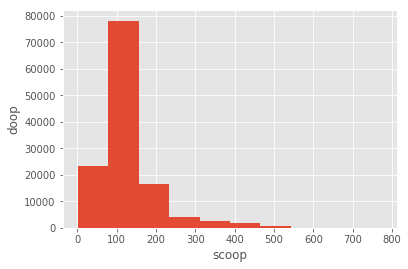

count    127132.000000
mean        127.488461
std          71.639692
min           1.000000
25%          84.000000
50%         108.000000
75%         144.000000
max         775.000000
Name: valuenum, dtype: float64
time: 564 ms


In [27]:
fig, ax = plt.subplots()
bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'PaO2'),'valuenum'].hist(ax=ax)

ax.set_ylabel('doop', fontsize='large')
ax.set_xlabel('scoop', fontsize='large')
plt.show()


print(
    bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'PaO2'),'valuenum'].describe()
)

# 8/24/18 
- debug bg_all_nosummary2 and see how many rows we have that correspond to the vent count and catgories. 


In [28]:
criteria1=ventcategory_df['vent_day1']!='None'
criteria2=ventcategory_df['vent_day2']!='None'
criteria3=ventcategory_df['vent_day3']!='None'

vent_pts= list(ventcategory_df[criteria1 ^ criteria2 ^ criteria3]['icustay_id'].unique()) #n=5822



#ventcategory_df[ventcategory_df['vent_day1']!='None' ^ ventcategory_df['vent_day2']!='None' ^ ventcategory_df['vent_day3']!='None']

time: 12.7 ms


In [30]:
bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'PaO2') & bg_all_nosummary_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=2792/5822
#bg_all_nosummary3_df.loc[bg_all_nosummary3_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=5822 (all)


2792

time: 377 ms


In [31]:
bg_all_nosummary_df['label'].value_counts()

PH                   203226
BASEEXCESS           191908
TOTALCO2             191908
PCO2                 191885
SPECIMEN             147405
PaO2                 127161
CALCIUM               90573
LACTATE               84499
SO2                   67456
PO2                   64738
TEMPERATURE           64714
GLUCOSE               59895
POTASSIUM             57970
INTUBATED             54755
FIO2                  51425
PEEP                  41820
TIDALVOLUME           38378
VENTILATIONRATE       30668
HEMOGLOBIN            22278
HEMATOCRIT            22278
SODIUM                19813
VENTILATOR            18325
CHLORIDE              14487
REQUIREDO2             8698
AADO2                  8677
O2FLOW                 4461
BICARBONATE            2847
METHEMOGLOBIN           745
CARBOXYHEMOGLOBIN       714
Name: label, dtype: int64

time: 265 ms


In [32]:
ventcategory_df[criteria1 ^ criteria2 ^ criteria3]['icustay_id'].nunique()

5822

time: 4.62 ms


### now comparing chartevents for FiO2 compared to bloodgas and vent settings. 

In [ ]:
#sql scripts

'''
select * from mimiciii.d_items
where lower(label) like '%fi_2%'
'''

"""select * from mimiciii.chartevents
where itemid in (1040,1206,185,
186,189,190,191,727,
3420,3421,3422,1863,5955,
2518,2981,7018,7041,7402,
7570,8517,227009,227010,226754)"""

In [33]:
#testing chartevents for all item id's that met my FIO2 sql script

CE_fio2_df= clinvar_fxn(
    'CE_fio2',
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/all/no_summary/CE_fio2.sql' 
)

(240317, 15)
time: 2min 51s


In [34]:
CE_fio2_df.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
1,34316023,9,150750,220597.0,190,2149-11-11 00:00:00,2149-11-10 23:31:00,17398,.60000002384185791,0.6,torr,NaN,NaN,None,NotStopd
2,34317097,9,150750,220597.0,190,2149-11-11 20:00:00,2149-11-11 20:02:00,17398,.5,0.5,torr,NaN,NaN,None,NotStopd
5,34363969,31,128652,254478.0,190,2108-08-25 19:05:00,2108-08-25 19:07:00,18366,.40000000596046448,0.4,torr,NaN,NaN,None,NotStopd
6,34320613,9,150750,220597.0,190,2149-11-14 12:00:00,2149-11-14 11:58:00,19585,.40000000596046448,0.4,torr,NaN,NaN,None,NotStopd
7,34316497,9,150750,220597.0,190,2149-11-11 08:00:00,2149-11-11 08:37:00,20992,.5,0.5,torr,NaN,NaN,None,NotStopd


time: 20.2 ms


In [36]:
#bg_all_nosummary3_df.loc[bg_all_nosummary3_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=5822 (all)


CE_fio2_df.loc[CE_fio2_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=2035 
bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'FIO2') & bg_all_nosummary_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=2739/5822

2739

time: 344 ms


In [37]:
bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'FIO2') & bg_all_nosummary_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].nunique() #n=2739/5822

2739

time: 247 ms


In [39]:
#looking at intersection

ce_list= list(CE_fio2_df.loc[CE_fio2_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].unique())
bg_list= list(bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'FIO2') & bg_all_nosummary_df['icustay_id'].isin(vent_pts) ,:]['icustay_id'].unique())

print(
    len(list(set(ce_list) & set(bg_list))), #only 1520/2035 overlap between lists
    len(set(ce_list + bg_list))
)

#515/3254 unique icustay_id's do not overlap. 

#note: the itemid's I used for FIO2 in chart events are the ones from the previous photo. 
#these may include some terms that are not appropriate for our analysis or could be categorical (ie FIO2 Alarm-High) and therefore may need to be.

#My overall take on this is that the bloodgas table seems to grab more comprehensive data than the chartevents table. The table is also a lot cleaner, whereas chartevents has n=23 different like '%fi_2%' variables.

1520 3254
time: 289 ms


In [40]:
CE_fio2_df.loc[CE_fio2_df['icustay_id'].isin(vent_pts) ,:].groupby('icustay_id')['charttime'].describe()

,count,unique,top,freq,first,last
icustay_id,,,,,,
200014.0,6,6,2105-02-16 23:15:00,1,2105-02-16 23:15:00,2105-02-17 18:00:00
200019.0,22,22,2178-07-09 15:00:00,1,2178-07-08 10:00:00,2178-07-10 08:00:00
200065.0,71,70,2120-03-23 01:00:00,2,2120-03-22 22:30:00,2120-04-02 03:00:00
200078.0,5,5,2131-08-01 19:00:00,1,2131-08-01 13:15:00,2131-08-01 20:30:00
200091.0,17,17,2185-08-16 06:00:00,1,2185-08-14 03:42:00,2185-08-16 15:00:00
200136.0,30,17,2174-03-26 18:00:00,4,2174-03-24 16:54:00,2174-03-26 18:00:00
200199.0,3,3,2186-05-28 03:30:00,1,2186-05-28 00:00:00,2186-05-28 07:00:00
200220.0,270,268,2148-02-01 08:00:00,3,2148-01-05 12:00:00,2148-02-12 13:40:00
200301.0,60,60,2167-07-02 03:00:00,1,2167-06-26 10:30:00,2167-07-05 19:00:00


time: 4 s


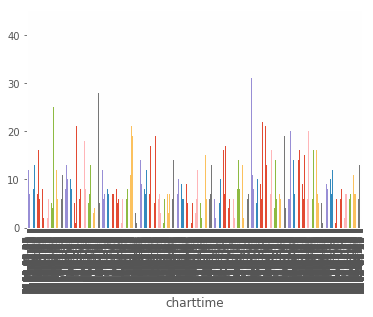

time: 3min 20s


In [48]:
import datetime as dt
CE_fio2_df.loc[CE_fio2_df['icustay_id'].isin(vent_pts) ,'charttime'].groupby(CE_fio2_df['charttime'].dt.date).count().plot(kind='bar')#['charttime'].count().plot(kind='bar')

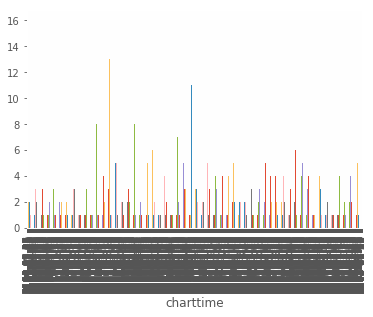

time: 2min 35s


In [54]:
#CE_fio2_df.loc[CE_fio2_df['icustay_id'].isin(vent_pts) ,'charttime'].groupby(CE_fio2_df['charttime'].dt.date).count().plot(kind='bar')#['charttime'].count().plot(kind='bar')

(
    bg_all_nosummary_df.loc[(bg_all_nosummary_df['label'] == 'FIO2') & bg_all_nosummary_df['icustay_id'].isin(vent_pts) ,'charttime']
    .groupby(pd.to_datetime(bg_all_nosummary_df['charttime']).dt.date)
    .count()
    .plot(kind='bar')
)

In [50]:
bg_all_nosummary_df.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,unique_var
607,9,150750,220597,2149-11-09 17:47:00,BASEEXCESS,1.0,1,2205972149-11-09 17:47:00
608,9,150750,220597,2149-11-09 17:47:00,CHLORIDE,103.0,103,2205972149-11-09 17:47:00
609,9,150750,220597,2149-11-09 17:47:00,FIO2,60.0,60,2205972149-11-09 17:47:00
610,9,150750,220597,2149-11-09 17:47:00,GLUCOSE,178.0,178,2205972149-11-09 17:47:00
611,9,150750,220597,2149-11-09 17:47:00,HEMATOCRIT,42.0,42,2205972149-11-09 17:47:00


time: 16.1 ms


In [44]:
import datetime as dt

time: 689 µs


# 8/8/18 exploring/ parsing through vent settings

In [287]:
list(ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'label']=='PEEP','value'].unique())

['4',
 '0',
 '1',
 '.80000001192092896',
 '2',
 '4.3000001907348633',
 '5',
 '1.5',
 '3',
 '6',
 '8',
 '10',
 '.40000000596046448',
 '.30000001192092896',
 '.60000002384185791',
 '12',
 '14',
 '1.2000000476837158',
 '1.3999999761581421',
 '2.7999999523162842',
 '2.5999999046325684',
 '9',
 '3.5',
 '.69999998807907104',
 '1.2999999523162842',
 '13.600000381469727',
 '11.600000381469727',
 '11.199999809265137',
 '18',
 '11.399999618530273',
 '11.800000190734863',
 '.10000000149011612',
 '.12999999523162842',
 '.039999999105930328',
 '5.4000000953674316',
 '3.9000000953674316',
 '8.5',
 '3.7000000476837158',
 '10.100000381469727',
 '3.4000000953674316',
 '4.1999998092651367',
 '4.0999999046325684',
 '6.3000001907348633',
 '10.600000381469727',
 '19',
 '17',
 '1.7000000476837158',
 '.89999997615814209',
 '7.5999999046325684',
 '9.6999998092651367',
 '7.0999999046325684',
 '1.1000000238418579',
 '2.2000000476837158',
 '2.5',
 '15',
 '1.6000000238418579',
 '2.4000000953674316',
 '16',
 '20',

time: 309 ms


In [206]:
ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'valuenum'].isnull(),:]

,icustay_id,charttime,label,valuenum,valueuom,value
94,294060.0,2109-11-04 18:00:00,Insp pressure,NaN,NaN,33%
103,294060.0,2109-11-04 19:58:00,Insp pressure,NaN,NaN,33%
388,291034.0,2156-11-26 13:00:00,Insp pressure,NaN,NaN,33%
405,252252.0,2121-04-18 13:00:00,Insp pressure,NaN,NaN,25%
406,252252.0,2121-04-18 18:10:00,Insp pressure,NaN,NaN,25%
543,243034.0,2170-06-13 09:00:00,Insp pressure,NaN,NaN,33%
552,243034.0,2170-06-13 20:00:00,Insp pressure,NaN,NaN,33%
553,243034.0,2170-06-14 07:00:00,Insp pressure,NaN,NaN,33%
554,243034.0,2170-06-21 15:40:00,Insp pressure,NaN,NaN,33%
556,243034.0,2170-06-13 11:45:00,Insp pressure,NaN,NaN,33%


time: 75.2 ms


In [102]:
ventsettings_all2_df.pivot('label')

ValueError: cannot label index with a null key

time: 524 ms


In [39]:
ventsettings_all2_df.head()

,icustay_id,charttime,label,valuenum,valueuom,value
9,254245.0,2142-04-25 00:30:00,PEEP,4.0,cmH2O,4
10,254245.0,2142-04-26 20:00:00,PEEP,0.0,cmH2O,0
11,254245.0,2142-04-25 06:00:00,PEEP,1.0,cmH2O,1
12,254245.0,2142-04-27 07:00:00,PEEP,0.0,cmH2O,0
13,254245.0,2142-04-26 07:18:00,PEEP,0.8,cmH2O,.80000001192092896


time: 9.78 ms


In [33]:
#icustay_id: 267059.0  test case
#t_0= 2182-11-12
#t_0+72 = 2182-11-15
#t_end_consec = 2183-11-15

#vaso_dose_df.loc[vaso_dose_df.loc[:,'icustay_id']==267059.0,:].sort_values('starttime')
ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'icustay_id']==267059.0,'charttime'].describe() #Timestamp('2182-11-19 20:55:00')
#Timestamp('2182-11-19 20:55:00')
#Timestamp('2183-01-15 04:00:00)


#QC CHECK LOOKS GOOD!

count                    3603
unique                    425
top       2182-12-13 05:25:00
freq                       12
first     2182-11-11 23:00:00
last      2183-01-15 12:36:00
Name: charttime, dtype: object

time: 81.1 ms


In [7]:
# picking back up a week later, 08/13/2018:
ventsettings_df.head()
#ventsettings_all2_df

,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
5,292972.0,2178-03-14 22:00:00,0,1,0,0
6,255356.0,2156-04-26 18:00:00,0,1,0,0
9,295273.0,2195-09-23 18:26:00,1,0,0,0
14,288354.0,2103-11-04 09:40:00,0,1,0,0
20,226799.0,2153-08-06 11:03:00,1,0,0,0


time: 27.4 ms


In [ ]:
#dfs:
#ventsettings_df : from the mimic team, has 4 coded columns for each icustay?
#ventsettings_all2_df : more parsed out parameters, a bit messy. 
#goal: need to look thru nelson's email and see what i need to extract from both of them.

In [43]:
ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'icustay_id']==271863.0,:]

,icustay_id,charttime,label,valuenum,valueuom,value
13785,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",40.000000,cmH2O,40
565150,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",10.000000,cmH2O,10
565151,271863.0,2105-01-24 00:49:00,minute volume,24.700001,L/min,24.700000762939453
565152,271863.0,2105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,NaN,NaN,Bipap Mask
565153,271863.0,2105-01-24 00:49:00,PEEP,5.000000,cmH2O,5
565901,271863.0,2105-01-24 00:00:00,O2 Delivery Device (both oxygen + vent calcula...,NaN,NaN,Non-Rebreather
565902,271863.0,2105-01-24 00:00:00,O2 Flow (lpm),15.000000,lpm,15
4213566,271863.0,2105-01-24 00:49:00,tidal volume,709.000000,ml/B,709
4213567,271863.0,2105-01-24 00:49:00,vent mode,NaN,NaN,CPAP+PS


time: 14.5 ms


In [308]:
ventsettings_all2_df['label'].unique()

array(['PEEP', 'Insp pressure',
       'High/Low/Peak/Mean/Neg insp force ("RespPressure")', 'TCPCV',
       'O2 Delivery Device (both oxygen + vent calculation)',
       'O2 Delivery Device#2', 'O2 Flow (lpm)', 'O2 Flow (lpm) #2',
       'minute volume', 'PlateauPressure', 'PCV', 'O2 Delivery Mode',
       'extubated', 'tidal volume', 'vent mode', 'PSVlevel', 'O2 Flow',
       'APRV pressure', 'O2 Flow (additional cannula)',
       'O2 Delivery Device(s)', 'vent type'], dtype=object)

time: 270 ms


In [72]:
#playing with melt
#ventsettings_all2_df.pivot(columns=['icustay_id'], values=['charttime','label','valuenum','valueuom','value'])
#ventsettings_all2_df.pivot?

test_df= ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'icustay_id']==271863.0,['icustay_id','charttime','label','value']]

time: 6.53 ms


In [168]:
#test_df.stack?
#test_df
test_df= (ventsettings_all2_df
          .loc[ventsettings_all2_df.loc[:,'icustay_id']==271863.0,
               ['icustay_id','charttime','label','value','valuenum']]
         )
#test_df=test_df.set_index('icustay_id')
#test_df=test_df.stack()
#test_df.pivot(index='icustay_id',columns='label', values=['charttime','value'])

#test_df=test_df.melt(id_vars=['icustay_id','charttime'])
#test_df=test_df.set_index('icustay_id')

test_df_melted= test_df.melt(id_vars=['icustay_id','charttime'], value_vars=list(test_df.columns)[2:], var_name='test', value_name='test2')
#test_df.stack(level=-1)#.pivot(columns='label',values='value')

#test_df_melted
#test_df_melted.pivot(index=['icustay_id','charttime'], columns='test', values='test2')#.stack()

#test_df.stack()
#test_df.stack()
#test_df.stack(level='icustay_id')

time: 16.2 ms


In [195]:
# def is_string(x):
#     if 

#test_df['value'].transform(lambda x : isinstance(x, str))
#test_df

test_df["unique_merge"] = test_df["icustay_id"].map(str) + test_df["charttime"].map(str)

# test_df

test_df_labels= test_df.loc[test_df.loc[:,'valuenum'].isnull(),:]

test_df_values= test_df.loc[test_df.loc[:,'valuenum'].notnull(),:]
test_df_values.rename(columns={'label':'vent_parameter'})
#test_df_valuesmerge 

test_df_concat =pd.merge(test_df_values,
                         test_df_labels.drop(['icustay_id','charttime', 'valuenum'], axis=1),
                         left_on= 'unique_merge',
                         right_on='unique_merge',
                         how = 'left'
                        )

time: 5.58 ms


In [196]:
test_df_values#['label','value','unique_merge']

,icustay_id,charttime,label,value,valuenum,unique_merge
13785,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",40,40.000000,271863.02105-01-24 00:49:00
565150,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",10,10.000000,271863.02105-01-24 00:49:00
565151,271863.0,2105-01-24 00:49:00,minute volume,24.700000762939453,24.700001,271863.02105-01-24 00:49:00
565153,271863.0,2105-01-24 00:49:00,PEEP,5,5.000000,271863.02105-01-24 00:49:00
565902,271863.0,2105-01-24 00:00:00,O2 Flow (lpm),15,15.000000,271863.02105-01-24 00:00:00
4213566,271863.0,2105-01-24 00:49:00,tidal volume,709,709.000000,271863.02105-01-24 00:49:00


time: 9.27 ms


In [197]:
test_df_labels

,icustay_id,charttime,label,value,valuenum,unique_merge
565152,271863.0,2105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask,NaN,271863.02105-01-24 00:49:00
565901,271863.0,2105-01-24 00:00:00,O2 Delivery Device (both oxygen + vent calcula...,Non-Rebreather,NaN,271863.02105-01-24 00:00:00
4213567,271863.0,2105-01-24 00:49:00,vent mode,CPAP+PS,NaN,271863.02105-01-24 00:49:00


time: 8.29 ms


In [202]:
#test_df_labels

#test_df_concat= pd.concat([test_df_values, test_df_labels], join='inner', axis = 1)

test_df_concat =pd.merge(test_df_values, test_df_labels.drop(['icustay_id','charttime', 'valuenum'], axis=1), left_on= 'unique_merge', right_on='unique_merge', how = 'left')

time: 4.72 ms


In [203]:
test_df_concat

,icustay_id,charttime,label_x,value_x,valuenum,unique_merge,label_y,value_y
0,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",40,40.000000,271863.02105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask
1,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",40,40.000000,271863.02105-01-24 00:49:00,vent mode,CPAP+PS
2,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",10,10.000000,271863.02105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask
3,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",10,10.000000,271863.02105-01-24 00:49:00,vent mode,CPAP+PS
4,271863.0,2105-01-24 00:49:00,minute volume,24.700000762939453,24.700001,271863.02105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask
5,271863.0,2105-01-24 00:49:00,minute volume,24.700000762939453,24.700001,271863.02105-01-24 00:49:00,vent mode,CPAP+PS
6,271863.0,2105-01-24 00:49:00,PEEP,5,5.000000,271863.02105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask
7,271863.0,2105-01-24 00:49:00,PEEP,5,5.000000,271863.02105-01-24 00:49:00,vent mode,CPAP+PS
8,271863.0,2105-01-24 00:00:00,O2 Flow (lpm),15,15.000000,271863.02105-01-24 00:00:00,O2 Delivery Device (both oxygen + vent calcula...,Non-Rebreather
9,271863.0,2105-01-24 00:49:00,tidal volume,709,709.000000,271863.02105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask


time: 12.5 ms


In [179]:
pd.concat?

time: 4.52 ms


Signature: pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
Docstring:
Concatenate pandas objects along a particular axis with optional set logic
along the other axes.

Can also add a layer of hierarchical indexing on the concatenation axis,
which may be useful if the labels are the same (or overlapping) on
the passed axis number.

Parameters
----------
objs : a sequence or mapping of Series, DataFrame, or Panel objects
    If a dict is passed, the sorted keys will be used as the `keys`
    argument, unless it is passed, in which case the values will be
    selected (see below). Any None objects will be dropped silently unless
    they are all None in which case a ValueError will be raised
axis : {0/'index', 1/'columns'}, default 0
    The axis to concatenate along
join : {'inner', 'outer'}, default 'outer'
    How to handle indexes on other axis(es)
join_axes : list of Index objects
    Spe

In [151]:
isinstance(5, str)

False

time: 1.83 ms


In [100]:
test_df= (ventsettings_all2_df
          .loc[ventsettings_all2_df.loc[:,'icustay_id']==271863.0,
               ['icustay_id','charttime','label','value']]
         )
test_df

,icustay_id,charttime,label,value
13785,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",40
565150,271863.0,2105-01-24 00:49:00,"High/Low/Peak/Mean/Neg insp force (""RespPressu...",10
565151,271863.0,2105-01-24 00:49:00,minute volume,24.700000762939453
565152,271863.0,2105-01-24 00:49:00,O2 Delivery Device (both oxygen + vent calcula...,Bipap Mask
565153,271863.0,2105-01-24 00:49:00,PEEP,5
565901,271863.0,2105-01-24 00:00:00,O2 Delivery Device (both oxygen + vent calcula...,Non-Rebreather
565902,271863.0,2105-01-24 00:00:00,O2 Flow (lpm),15
4213566,271863.0,2105-01-24 00:49:00,tidal volume,709
4213567,271863.0,2105-01-24 00:49:00,vent mode,CPAP+PS


time: 13.4 ms


In [103]:
test_df['label'].unique()

array(['High/Low/Peak/Mean/Neg insp force ("RespPressure")',
       'minute volume',
       'O2 Delivery Device (both oxygen + vent calculation)', 'PEEP',
       'O2 Flow (lpm)', 'tidal volume', 'vent mode'], dtype=object)

time: 3.06 ms


In [88]:
test_df.stack?

time: 5.83 ms


Signature: test_df.stack(level=-1, dropna=True)
Docstring:
Pivot a level of the (possibly hierarchical) column labels, returning a
DataFrame (or Series in the case of an object with a single level of
column labels) having a hierarchical index with a new inner-most level
of row labels.
The level involved will automatically get sorted.

Parameters
----------
level : int, string, or list of these, default last level
    Level(s) to stack, can pass level name
dropna : boolean, default True
    Whether to drop rows in the resulting Frame/Series with no valid
    values

Examples
----------
>>> s
     a   b
one  1.  2.
two  3.  4.

>>> s.stack()
one a    1
    b    2
two a    3
    b    4

Returns
-------
stacked : DataFrame or Series
File:      ~/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/frame.py
Type:      method


In [81]:
test_df.unstack?

time: 4.32 ms


Signature: test_df.unstack(level=-1, fill_value=None)
Docstring:
Unstack, a.k.a. pivot, Series with MultiIndex to produce DataFrame.
The level involved will automatically get sorted.

Parameters
----------
level : int, string, or list of these, default last level
    Level(s) to unstack, can pass level name
fill_value : replace NaN with this value if the unstack produces
    missing values

    .. versionadded: 0.18.0

Examples
--------
>>> s = pd.Series([1, 2, 3, 4],
...     index=pd.MultiIndex.from_product([['one', 'two'], ['a', 'b']]))
>>> s
one  a    1
     b    2
two  a    3
     b    4
dtype: int64

>>> s.unstack(level=-1)
     a  b
one  1  2
two  3  4

>>> s.unstack(level=0)
   one  two
a    1    3
b    2    4

Returns
-------
unstacked : DataFrame
File:      ~/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/series.py
Type:      method


In [47]:
ventsettings_all2_df.pivot?

time: 14.7 ms


Signature: ventsettings_all2_df.pivot(index=None, columns=None, values=None)
Docstring:
Reshape data (produce a "pivot" table) based on column values. Uses
unique values from index / columns to form axes of the resulting
DataFrame.

Parameters
----------
index : string or object, optional
    Column name to use to make new frame's index. If None, uses
    existing index.
columns : string or object
    Column name to use to make new frame's columns
values : string or object, optional
    Column name to use for populating new frame's values. If not
    specified, all remaining columns will be used and the result will
    have hierarchically indexed columns

Returns
-------
pivoted : DataFrame

See also
--------
DataFrame.pivot_table : generalization of pivot that can handle
    duplicate values for one index/column pair
DataFrame.unstack : pivot based on the index values instead of a
    column

Notes
-----
For finer-tuned control, see hierarchical indexing documentation along
with the r

In [51]:
#ventsettings_all2_df.pivot_table?
ventsettings_all2_df.pivot_table(values='value', index=['icustay_id','charttime'], columns=['label'])

DataError: No numeric types to aggregate

time: 285 ms


In [9]:
ventsettings_all2_df['label'].unique()

array(['PEEP', 'Insp pressure',
       'High/Low/Peak/Mean/Neg insp force ("RespPressure")', 'TCPCV',
       'O2 Delivery Device (both oxygen + vent calculation)',
       'O2 Delivery Device#2', 'O2 Flow (lpm)', 'O2 Flow (lpm) #2',
       'minute volume', 'PlateauPressure', 'PCV', 'O2 Delivery Mode',
       'extubated', 'tidal volume', 'vent mode', 'PSVlevel', 'O2 Flow',
       'APRV pressure', 'O2 Flow (additional cannula)',
       'O2 Delivery Device(s)', 'vent type'], dtype=object)

time: 318 ms


#Patients with a value of "CPAP mask" or “Bipap mask” under the label “O2 Delivery Device” and ”O2 Delivery Device#2” are on non-invasive.

In [35]:
list1=['O2 Delivery Device (both oxygen + vent calculation)','O2 Delivery Device#2']
#list2=['CPAP Mask','Bipap Mask']

non_invasive_pts= list(
    ventsettings_all2_df.loc[
        ventsettings_all2_df.loc[:,'label'].isin(list1) & ventsettings_all2_df.loc[:,'value'].isin(list2),'icustay_id'
    ].unique()
)

time: 243 ms


In [317]:
 # #QC  8/14/18
    
    #WHY IS NONE IN O2 THERAPY in ventsettings.sql?

# list1=['O2 Delivery Device (both oxygen + vent calculation)','O2 Delivery Device#2']
# #list2=['CPAP Mask','Bipap Mask']


# (ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'label'].isin(list1)
#                           & ventsettings_all2_df.loc[:,'value']=='None',:])


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

time: 351 ms


In [42]:
non_invasive_pts

[271863.0,
 250569.0,
 239048.0,
 243281.0,
 271378.0,
 203568.0,
 273215.0,
 243406.0,
 203326.0,
 292198.0,
 251380.0,
 270170.0,
 271485.0,
 246704.0,
 299445.0,
 256435.0,
 292334.0,
 237950.0,
 206077.0,
 224720.0,
 202289.0,
 282693.0,
 264350.0,
 239319.0,
 272045.0,
 245223.0,
 277258.0,
 240364.0,
 285089.0,
 234633.0,
 245947.0,
 266389.0,
 219830.0,
 249260.0,
 229566.0,
 286492.0,
 216321.0,
 246869.0,
 233854.0,
 237528.0,
 229824.0,
 227102.0,
 278755.0,
 206850.0,
 287257.0,
 299395.0,
 289059.0,
 247643.0,
 224321.0,
 278490.0,
 228694.0,
 218289.0,
 260904.0,
 249913.0,
 209713.0,
 267439.0,
 276562.0,
 290266.0,
 238179.0,
 240814.0,
 255786.0,
 269388.0,
 239873.0,
 270280.0,
 213189.0,
 290818.0,
 293440.0,
 203165.0,
 292676.0,
 244258.0,
 232138.0,
 244105.0,
 297030.0,
 239378.0,
 213027.0,
 299895.0,
 272169.0,
 277782.0,
 235244.0,
 215436.0,
 274844.0,
 222530.0,
 246472.0,
 223798.0,
 255377.0,
 288929.0,
 262074.0,
 252193.0,
 288353.0,
 260571.0,
 278347.0,

time: 4.14 ms


In [40]:
ventsettings_all2_df.loc[
    ventsettings_all2_df.loc[:,'label'].isin(list1),'icustay_id'].nunique()

5329

time: 110 ms


In [39]:

ventsettings_all2_df.loc[
    ventsettings_all2_df.loc[:,'label'].isin(list1) & ~ventsettings_all2_df.loc[:,'value'].isin(list2),'icustay_id'].nunique()

5328

time: 235 ms


In [30]:
ventsettings_all2_df.loc[~ventsettings_all2_df.loc[:,'icustay_id'].isin(non_invasive_pts),'icustay_id'].nunique()

11235

time: 333 ms


In [32]:
ventsettings_all2_df.loc[ventsettings_all2_df.loc[:,'value'].isin(list2),'icustay_id'].nunique()

133

time: 140 ms


In [31]:
ventsettings_all2_df['icustay_id'].nunique()

11368

time: 29.5 ms


# 08/06/2018: 
looking for UTI related variables in mimic

In [4]:
labs_all_nosummary_df.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
439,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0
777,9,150750,220597,2149-11-09 11:20:00,ANION GAP,13.0
778,9,150750,220597,2149-11-09 11:20:00,BICARBONATE,30.0
779,9,150750,220597,2149-11-09 11:20:00,CHLORIDE,100.0
780,9,150750,220597,2149-11-09 11:20:00,CREATININE,1.2


time: 14.5 ms


In [3]:
labs_all_nosummary_df.describe(include ='all', ) #the .T transposes the data. makes more sense. 

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
count,3.036173e+06,3.036173e+06,3.036173e+06,3036155,3036155,3.036141e+06
unique,NaN,NaN,NaN,397363,19,NaN
top,NaN,NaN,NaN,2142-11-08 05:00:00,POTASSIUM,NaN
freq,NaN,NaN,NaN,57,262303,NaN
mean,3.902185e+04,1.500443e+05,2.499607e+05,NaN,NaN,5.436563e+01
std,2.897971e+04,2.893826e+04,2.891558e+04,NaN,NaN,8.125118e+01
min,9.000000e+00,1.000030e+05,2.000120e+05,NaN,NaN,5.000000e-02
25%,1.505400e+04,1.252060e+05,2.247480e+05,NaN,NaN,6.300000e+00
50%,2.864600e+04,1.492070e+05,2.505660e+05,NaN,NaN,2.100000e+01
75%,6.320100e+04,1.760710e+05,2.746040e+05,NaN,NaN,9.800000e+01


time: 2.07 s


In [5]:
(labs_all_nosummary_df.groupby(['label'])['valuenum','label'].describe())

#['subject_id','valuenum','label']

valuenum                                                     \
                count        mean         std   min    25%    50%    75%   
label                                                                      
ALBUMIN       33500.0    2.850603    0.655930  1.00    2.4    2.8    3.3   
ANION GAP    190517.0   13.748332    4.056762  1.00   11.0   13.0   16.0   
BANDS          9329.0    8.154883    9.349695  0.80    2.0    5.0   11.0   
BICARBONATE  193301.0   25.107454    5.265381  2.00   22.0   25.0   28.0   
BILIRUBIN     53711.0    3.766109    6.897965  0.10    0.5    1.1    3.4   
BUN          195627.0   32.142731   25.027576  1.00   15.0   24.0   42.0   
CHLORIDE     210698.0  104.379224    6.558416  1.60  100.0  104.0  108.0   
CREATININE   196255.0    1.580378    1.626819  0.05    0.7    1.0    1.8   
GLUCOSE      247026.0  133.927711   61.999815  1.00  101.0  121.0  150.0   
HEMATOCRIT   229467.0   30.226008    5.073648  2.10   26.8   29.7   33.0   
HEMOGLOBIN   197708.0   10.177374    1.770196  1.20    9.0   10.0   11.2   
INR          118573.0    1.641751    1.097141  0.10    1.2    1.3    1.7   
LACTATE       73417.0    2.698157    2.633924  0.05    1.2    1.8    3.1   
PLATELET     182303.0  245.357142  164.736509  5.00  130.0  213.0  320.0   
POTASSIUM    262302.0    4.092364    0.663286  0.60    3.7    4.0    4.4   
PT           118587.0   17.055080    7.860769  7.40   13.4   14.7   17.8   
PTT          126289.0   44.795158   25.429692  0.15   28.6   35.2   52.5   
SODIUM       220185.0  138.889363    5.368620  3.50  136.0  139.0  142.0   
WBC          177346.0   12.046815    9.014932  0.10    7.5   10.5   14.6   

                     
                max  
label                
ALBUMIN         6.9  
ANION GAP      74.0  
BANDS          79.0  
BICARBONATE    60.0  
BILIRUBIN      82.2  
BUN           290.0  
CHLORIDE      149.0  
CREATININE    138.0  
GLUCOSE      2270.0  
HEMATOCRIT     61.3  
HEMOGLOBIN     21.6  
INR            48.8  
LACTATE        36.0  
PLATELET     2813.0  
POTASSIUM      26.5  
PT            150.0  
PTT           150.0  
SODIUM        183.0  
WBC           471.7

time: 635 ms


In [6]:
#looking at all the different lab types in lab_events and lab_ditems. attempting to find following unfound clinical variables:
#Nitrite (urine), Leukocytes esterase (urine), EPAP (cmH2O), IPAP (cmH2O). 


labs_test_types_sql = query_schema + """
select dl.label 
FROM mimiciii.labevents le
--LEFT JOIN mimiciii.labevents le
--ON le.subject_id = ie.subject_id AND le.hadm_id = ie.hadm_id
LEFT JOIN mimiciii.d_labitems dl
ON le.itemid = dl.itemid
group by dl.label;
"""
#.format(tuple(patients))

#AND le.subject_id in  {}
    
labs_test_types_df=pd.read_sql_query(labs_test_types_sql,conn)   

time: 14.3 s


In [11]:
labs_test_types_df["label"].value_counts()

Lipase                                 1
Albumin/Creatinine, Urine              1
Ethanol                                1
Ventilation Rate                       1
Reticulocyte Count, Manual             1
Other Cell                             1
Platelet Clumps                        1
Bacteria                               1
CD8                                    1
WBC, Other Fluid                       1
Creatine Kinase (CK)                   1
Inpatient Hematology/Oncology Smear    1
Sodium, Stool                          1
CD34                                   1
Amylase                                1
Urine Appearance                       1
Glucose, Joint Fluid                   1
Creatinine                             1
Nucleated Red Cells                    1
Potassium, Stool                       1
RBC, Joint Fluid                       1
Beta-2 Microglobulin                   1
Hemosiderin                            1
Calculated TBG                         1
Hyaline Casts   

time: 6.84 ms


In [18]:

sleep_vent_types_sql = query_schema + """
select dl.label, le.itemid, icd.icd9_code
FROM mimiciii.labevents le
LEFT JOIN mimiciii.d_labitems dl
ON le.itemid = dl.itemid
LEFT JOIN mimiciii.diagnoses_icd icd
ON le.hadm_id = icd.hadm_id
where 
--lower(dl.label) LIKE '%ipap%' OR
--lower(dl.label) LIKE '%urin%' OR
--lower(dl.label) LIKE '%nitrite%'
--group by dl.label, le.itemid
--ORDER by dl.label, le.itemid
icd.icd9_code like '32726'
group by dl.label, le.itemid, icd.icd9_code
ORDER by dl.label, le.itemid, icd.icd9_code;
"""
#.format(tuple(patients))

#AND le.subject_id in  {}
    
sleep_vent_types_df=pd.read_sql_query(sleep_vent_types_sql,conn)   

time: 53.1 ms


In [20]:
sleep_vent_types_df['label'].unique()

array(['Absolute A1c', 'Absolute Hemoglobin', 'Acetaminophen', 'Acetone',
       'Alanine Aminotransferase (ALT)', 'Albumin',
       'Albumin/Creatinine, Urine', 'Albumin, Urine',
       'Alkaline Phosphatase', 'Alveolar-arterial Gradient', 'Ammonia',
       'Amorphous Crystals', 'Amphetamine Screen, Urine', 'Amylase',
       'Anion Gap', 'Anisocytosis', 'Anti-Nuclear Antibody',
       'Anti-Thyroglobulin Antibodies', 'Asparate Aminotransferase (AST)',
       'Atypical Lymphocytes', 'Bacteria', 'Bands', 'Barbiturate Screen',
       'Barbiturate Screen, Urine', 'Base Excess', 'Basophilic Stippling',
       'Basophils', 'Benzodiazepine Screen',
       'Benzodiazepine Screen, Urine', 'Bicarbonate',
       'Bicarbonate, Urine', 'Bilirubin', 'Bilirubin, Direct',
       'Bilirubin, Indirect', 'Bilirubin, Total', 'Blood',
       'Blue Top Hold', 'Calcium Oxalate Crystals', 'Calcium, Total',
       'Calculated Bicarbonate, Whole Blood', 'Calculated TBG',
       'Calculated Thyroxine (T4) Index

time: 4.43 ms


In [15]:
uti_labs_test_types_df['label'].unique() #521 unique

array(['24 hr Calcium', '24 hr Creatinine', '24 hr Protein',
       '25-OH Vitamin D', 'Absolute A1c', 'Absolute CD3 Count',
       'Absolute CD4 Count', 'Absolute CD8 Count', 'Absolute Hemoglobin',
       'Absolute Lymphocyte Count', 'Acanthocytes', 'Acetaminophen',
       'Acetone', 'ADP', 'Alanine Aminotransferase (ALT)', 'Albumin',
       '<Albumin>', 'Albumin, Ascites', 'Albumin, Body Fluid',
       'Albumin/Creatinine, Urine', 'Albumin, Pleural', 'Albumin, Urine',
       'Alkaline Phosphatase', 'Alpha-Fetoprotein',
       'Alveolar-arterial Gradient', 'Amikacin', 'Ammonia',
       'Ammonium Biurate', 'Amorphous Crystals',
       'Amphetamine Screen, Urine', 'Amylase', 'Amylase, Ascites',
       'Amylase, Body Fluid', 'Amylase/Creatinine Ratio, Urine',
       'Amylase, Joint Fluid', 'Amylase, Pleural', 'Amylase, Urine',
       'Anion Gap', 'Anisocytosis', 'Anticardiolipin Antibody IgG',
       'Anticardiolipin Antibody IgM', 'Anti-Mitochondrial Antibody',
       'Anti-Neutrophil C

time: 4.57 ms


In [ ]:
"""
select dl.label 
FROM mimiciii.icustays ie
LEFT JOIN mimiciii.labevents le
ON le.subject_id = ie.subject_id AND le.hadm_id = ie.hadm_id
--FROM mimiciii.labevents le
--LEFT JOIN mimiciii.labevents le
--ON le.subject_id = ie.subject_id AND le.hadm_id = ie.hadm_id
LEFT JOIN mimiciii.d_labitems dl
--WHERE ie.subject_id in {}
ON le.itemid = dl.itemid
group by dl.label;
"""


# descriptive statistics for cohort. notes


get the missingness % for each variable (ie for each variable how many patients never have any entry?). repeat above for all variables. 

### NEED TO DOUBLE CHECK THAT THESE ICUSTAY ID ARE ONLY FOR THOSE INCLUDED IN STUDY



In [83]:
#labs_all48[1:1000].groupby(['subject_id', 'label'])['valuenum'].isnull()

#drop duplicates for all 

#s.isnull().sum()

lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

lab_na_testvar.value_counts()
#wine['country'].nunique()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

time: 13.5 ms


In [51]:
labs_all48['label'].isnull().sum()

AttributeError: Cannot access callable attribute 'isnull' of 'DataFrameGroupBy' objects, try using the 'apply' method

time: 10.1 ms


In [89]:
icustay_list= list(cohort_df['icustay_id'].unique())

time: 4.28 ms


In [103]:
#task: get the missingness % for each variable (ie for each variable how many patients never have any entry?)

#lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

#lab_na_testvar.value_counts()


####FIRST THINGS FIRST, FILTER ONLY TO ICUSTAY OF INTEREST.

labs_all48= labs_all48[labs_all48['icustay_id'].isin(icustay_list)] #good


#my strat, drop na from labs_all48, then drop duplicate for each patient lab.


labs_all48_notnull= labs_all48[labs_all48['valuenum'].notnull()]

#labs_all48_notnull.groupby(['subject_id'])['label'].count()
labs_all48_notnull.drop_duplicates(['subject_id','label'])['label'].value_counts()
#labs_all48['subject_id'].nunique()
#labs_all48['subject_id','icustay_id','charttime','label','valuenum'.dropna()

CHLORIDE       11415
GLUCOSE        11415
SODIUM         11415
POTASSIUM      11415
BUN            11414
CREATININE     11414
BICARBONATE    11410
HEMATOCRIT     11408
WBC            11406
PLATELET       11405
HEMOGLOBIN     11404
ANION GAP      11395
PT             10771
INR            10767
PTT            10738
LACTATE         8947
BILIRUBIN       7451
ALBUMIN         6457
BANDS           2626
Name: label, dtype: int64

time: 181 ms


In [136]:
%whos

Variable        Type             Data/Info
------------------------------------------
ConfigManager   MetaHasTraits    <class 'notebook.services<...>g.manager.ConfigManager'>
Counter         type             <class 'collections.Counter'>
Memory          type             <class 'sklearn.externals.joblib.memory.Memory'>
asyncio         module           <module 'asyncio' from '/<...>3.6/asyncio/__init__.py'>
bg_all48        DataFrame                 subject_id  hadm<...>1396199 rows x 6 columns]
cm              ConfigManager    <notebook.services.config<...>er object at 0x10ab9bc50>
cohort_df       DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
collections     module           <module 'collections' fro<...>collections/__init__.py'>
dt              type             <class 'datetime.datetime'>
final_pt_df2    DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
getpass         module           <module 'getpass' from '/<...>ib/python3.6/getpass.p

In [102]:
labs_all48_notnull['subject_id'].nunique()

11417

time: 13.7 ms


In [162]:
"""
    get the # of filled vs missign values for each variable for our cohort.
    Args:
    -----
    df: dataframe
        name of dataframe initialized in this workbook
    valuenum_col: string
        name of column with the numerical or text variable in question
    label_col: string
        name of column with the lab value label in question
    Returns:
    -----
    filled_summary: df
        list of all variables with # filled values
    missing_summary: df
        list of all variables with # missing values
    percent_summary: df
        list of all variables with # filled values/ # total patients
    """

def missing_fxn(df, valuenum_col, label_col):
    if 'icustay_id' in list(df):
        df= df[df['icustay_id'].isin(list(cohort_df['icustay_id'].unique()))] #good
    else:
        df= df[df['subject_id'].isin(
            list(cohort_df['subject_id'].unique()))] 

    df_notnull = df[df[valuenum_col].notnull()]
    df_null = df[df[valuenum_col].isnull()]
    df_filtered = df.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    
    filled_summary= df_notnull.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    missing_summary = df_null.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    percent_summary = 100*(filled_summary / df_filtered)
    
    #missing_plot=(missing_summary.sort_index().plot.bar(title = f'# of missing values in {df}'))
    
    #filled_summary, missing_summary, percent_summary, 
    return(filled_summary, missing_summary, percent_summary)

time: 22.1 ms


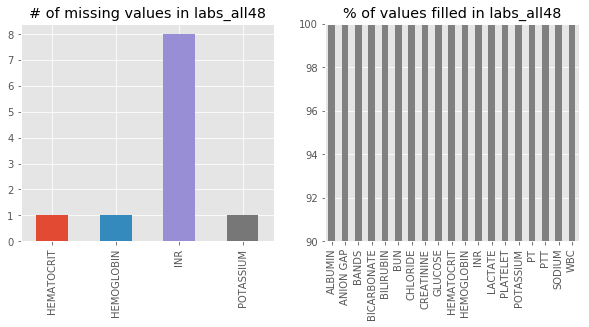

time: 795 ms


In [201]:
#labs
var1, var2, var3,  = missing_fxn(labs_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in labs_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

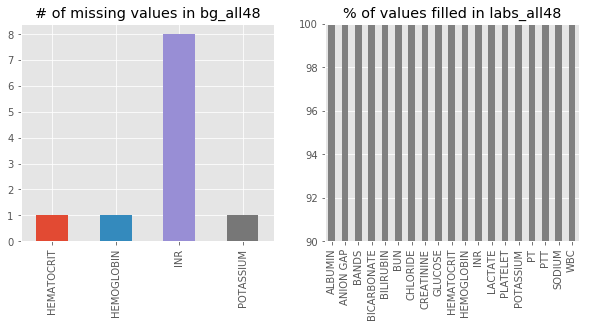

time: 721 ms


In [203]:
#bloodgas, is exact same as labs, 2xcheck
del var1, var2, var3
var1, var2, var3,  = missing_fxn(bg_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in bg_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

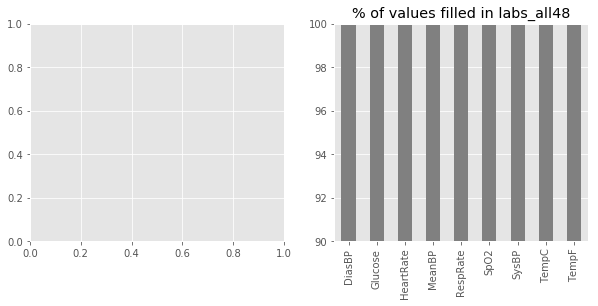

time: 2.08 s


In [223]:

del var1, var2, var3
var1, var2, var3,  = missing_fxn(vital_all48, 'valuenum', 'vitalid')
fig, axs = plt.subplots(1,2,figsize=(10,4))
if var2.notnull == True: 
    ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in vital_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))




In [ ]:
labs_by_pt

In [ ]:
# cnt = (wine.groupby(
#     ['country','points'])['price'].agg(['count','min','max','mean']
#                                       ).sort_values(by = 'mean',ascending = False)[:10]
# )



In [226]:
#bg_all48 #1396199 rows × 6 columns
#labs_all48 # 817014 rows × 6 columns
labs_all48.loc[labs_all48.loc[:,'label']=='BICARBONATE',:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
5,4,185777,294638,2191-03-16 05:42:00,BICARBONATE,21.0
21,4,185777,294638,2191-03-17 06:00:00,BICARBONATE,21.0
36,19,109235,273430,2108-08-06 01:08:00,BICARBONATE,22.0
51,19,109235,273430,2108-08-07 05:07:00,BICARBONATE,21.0
155,21,111970,216859,2135-01-30 19:05:00,BICARBONATE,23.0
173,21,111970,216859,2135-01-31 05:20:00,BICARBONATE,24.0
189,21,111970,216859,2135-02-01 02:59:00,BICARBONATE,20.0
204,25,129635,203487,2160-11-02 01:05:00,BICARBONATE,23.0
219,25,129635,203487,2160-11-02 03:59:00,BICARBONATE,21.0
230,25,129635,203487,2160-11-02 06:56:00,BICARBONATE,24.0


time: 189 ms


# VASO_DF EXPLORE

In [9]:
vaso_df.head()

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN


time: 17.4 ms


In [6]:
vaso_df.describe(include ='all', ).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
charttime,941,221,2163-04-09 15:15:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cv_rate_norepinephrine,672,NaN,NaN,NaN,0.1024,0.0745894,0,0.04,0.1,0.15,0.5
cv_rate_epinephrine,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cv_rate_dopamine,237,NaN,NaN,NaN,9.67089,2.33645,2,10,10,10,20
cv_rate_dobutamine,32,NaN,NaN,NaN,1.89062,1.20305,0,0.75,2.5,2.5,4
icustay_id,18992,NaN,NaN,NaN,249300,28450.5,200087,224474,249012,272764,299950
starttime,18992,17940,2144-08-27 00:50:00,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rate_norepinephrine,15329,NaN,NaN,NaN,0.176186,0.53856,0.0033003,0.060007,0.119102,0.224359,38.7485
rate_epinephrine,903,NaN,NaN,NaN,0.0923792,0.64535,0.00400014,0.0200091,0.0399918,0.0801056,19.2444
rate_dopamine,2454,NaN,NaN,NaN,9.75285,80.8013,0.499961,4.50076,6.0459,10.0168,4000


time: 222 ms


In [5]:
vaso_df.nunique()

charttime                   221
cv_rate_norepinephrine       24
cv_rate_epinephrine           0
cv_rate_dopamine              4
cv_rate_dobutamine            7
icustay_id                 1370
starttime                 17940
rate_norepinephrine       13821
rate_epinephrine            845
rate_dopamine              2060
rate_dobutamine             291
dtype: int64

time: 35.3 ms


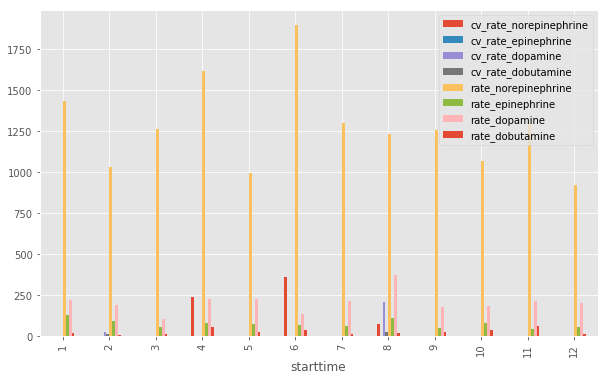

time: 422 ms


In [123]:
#To show the count of variables by month:
vaso_df['starttime']=pd.to_datetime(vaso_df['starttime'])

exclude_col= ['charttime','icustay_id','starttime']
vaso_df.loc[:, ~vaso_df.columns.isin(exclude_col)].groupby(test1["starttime"].dt.month).count().plot(kind="bar")

#interesting that so many cv_rate_norepinephrine's are in june and april. 

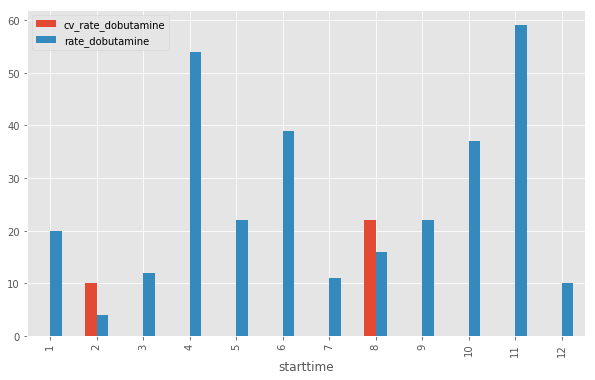

time: 227 ms


In [110]:
vaso_df.loc[:, vaso_df.columns.isin(['rate_dobutamine','cv_rate_dobutamine'])].groupby(vaso_df["starttime"].dt.month).count().plot(kind="bar")
#oops it would appear it is cv_rate_norepinephrine 

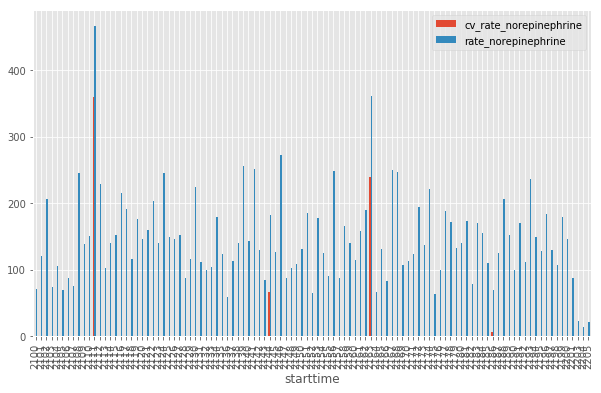

time: 1.28 s


In [136]:
vaso_df.loc[:, vaso_df.columns.isin(
    ['rate_norepinephrine','cv_rate_norepinephrine'])].groupby(
    vaso_df["starttime"].dt.year).count().plot(kind="bar")

#this is interesting, why do i only have cv_norepinephrine for certain years? 



In [135]:
table1= vaso_df.loc[:, vaso_df.columns.isin(
    ['cv_rate_norepinephrine'])].groupby(
    vaso_df["starttime"].dt.year).count()

table1.loc[table1.loc[:,'cv_rate_norepinephrine']!=0,:]
#strange that cv_rate_norepinephrine only occurs
#in 4 years: 2111, 2144, 2163, 2186. 

,cv_rate_norepinephrine
starttime,
2111,360
2144,66
2163,240
2186,6


time: 10.6 ms


In [126]:
vaso_df.loc[:, vaso_df.columns.isin(['cv_rate_norepinephrine'])].notnull().groupby(vaso_df["starttime"].dt.year).describe()

cv_rate_norepinephrine                   
                           count unique    top freq
starttime                                          
2100                          76      1  False   76
2101                         176      1  False  176
2102                         218      1  False  218
2103                         119      1  False  119
2104                         126      1  False  126
2105                         112      1  False  112
2106                          93      1  False   93
2107                          87      1  False   87
2108                         264      1  False  264
2109                         168      1  False  168
2110                         187      1  False  187
2111                         496      2   True  360
2112                         258      1  False  258
2113                         145      1  False  145
2114                         156      1  False  156
2115                         171      1  False  171
2116                         268      1  False  268
2117                         221      1  False  221
2118                         157      1  False  157
2119                         195      1  False  195
2120                         157      1  False  157
2121                         248      1  False  248
2122                         233      1  False  233
2123                         151      1  False  151
2124                         281      1  False  281
2125                         179      1  False  179
2126                         196      1  False  196
2127                         167      1  False  167
2128                         106      1  False  106
2129                         177      1  False  177
...                          ...    ...    ...  ...
2175                          91      1  False   91
2176                         106      1  False  106
2177                         256      1  False  256
2178                         187      1  False  187
2179                         177      1  False  177
2180                         191      1  False  191
2181                         257      1  False  257
2182                         112      1  False  112
2183                         204      1  False  204
2184                         162      1  False  162
2185                         145      1  False  145
2186                         121      2  False  115
2187                         143      1  False  143
2188                         266      1  False  266
2189                         172      1  False  172
2190                         111      1  False  111
2191                         214      1  False  214
2192                         144      1  False  144
2193                         299      1  False  299
2194                         182      1  False  182
2195                         150      1  False  150
2196                         248      1  False  248
2197                         184      1  False  184
2198                         161      1  False  161
2199                         219      1  False  219
2200                         213      1  False  213
2201                         131      1  False  131
2203                          23      1  False   23
2204                          16      1  False   16
2205                          40      1  False   40

[105 rows x 4 columns]

time: 327 ms


In [77]:
vaso_df.head()

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN


time: 107 ms


In [120]:
test1

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine,starttime_dt,starttime_strf,peroid,date
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN,2188-03-17 03:40:00,2188-03-17,2188-03,2188-03-17 03:40:00
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN,2188-03-17 09:00:00,2188-03-17,2188-03,2188-03-17 09:00:00
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN,2188-03-16 23:00:00,2188-03-16,2188-03,2188-03-16 23:00:00
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN,2188-03-16 23:30:00,2188-03-16,2188-03,2188-03-16 23:30:00
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN,2188-03-17 02:00:00,2188-03-17,2188-03,2188-03-17 02:00:00
21,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-18 10:30:00,0.040342,NaN,NaN,NaN,2188-03-18 10:30:00,2188-03-18,2188-03,2188-03-18 10:30:00
22,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-18 11:30:00,0.030286,NaN,NaN,NaN,2188-03-18 11:30:00,2188-03-18,2188-03,2188-03-18 11:30:00
23,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 17:32:00,0.074594,NaN,NaN,NaN,2188-03-17 17:32:00,2188-03-17,2188-03,2188-03-17 17:32:00
24,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 10:00:00,0.084662,NaN,NaN,NaN,2188-03-17 10:00:00,2188-03-17,2188-03,2188-03-17 10:00:00
25,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 00:29:00,0.200434,NaN,NaN,NaN,2188-03-17 00:29:00,2188-03-17,2188-03,2188-03-17 00:29:00


time: 49.4 ms


In [146]:
#visualizing serum lactate

#is lactate in lab same as serum lactate?

#(labs_all48.groupby(['label'])['valuenum','label'].describe())
#labs_all48["charttime"])= labs_all48(pd.to_datetime(vaso_df["charttime"])

labs_all48.loc[labs_all48.loc[:,'label']=='LACTATE',:].groupby(labs_all48(pd.to_datetime(labs_all48["charttime"]).dt.year).count().plot(kind="bar"))

#labs_all48.head()
#.groupby(vaso_df["starttime"].dt.year).count().plot(kind="bar")

TypeError: 'DataFrame' object is not callable

time: 431 ms


# comparing epinephrine extracted from sofa score modified sql and from epinephrine dose sql

In [127]:
#epinephrine dose

"""
n=2216
"""
epi_dose_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/13072018_epi_dose_df.csv')
#epinephrine sofa

#melting vaso_df to make it easier to highlight only epinephrine
vaso_df_melted=vaso_df.melt(
    id_vars=['charttime', 'icustay_id','starttime'])[
    vaso_df.melt(id_vars=['charttime', 'icustay_id','starttime'])[
        'value'].notnull()]
#epinephrine sofa 
"""
n=903
"""

epi_sofa=vaso_df_melted.loc[
    vaso_df_melted.loc[:,'variable'].isin([
        'cv_rate_epinephrine','rate_epinephrine']),:]


print(epi_sofa.shape,epi_dose_df.shape )

time: 64 ms


#notes:
- epi_dose_df['vaso_rate'] == epi_sofa['value']   #these are equal. 

In [131]:
epi_dose_df.head()
epi_dose_df.loc[epi_dose_df.loc[:,'icustay_id']==289413.0,:]

,Unnamed: 0,icustay_id,starttime,endtime,vaso_rate,vaso_amount
1923,6956,289413.0,2118-09-20 17:00:00,2118-09-20 18:56:00,0.030009,0.342183


time: 9.21 ms


In [130]:
epi_sofa.head()
epi_sofa.loc[epi_sofa.loc[:,'icustay_id']==289413.0,:]


,charttime,icustay_id,starttime,variable,value
95068,NaN,289413.0,2118-09-20 17:00:00,rate_epinephrine,0.030009


time: 9.63 ms


In [135]:
val= np.intersect1d(epi_dose_df["icustay_id"], epi_sofa["icustay_id"])
print (len(val)) #only 164 overlap...

val2= np.intersect1d(epi_sofa["icustay_id"],epi_dose_df["icustay_id"])

print (len(val2)) #n=164 overlap

print(epi_sofa["icustay_id"].nunique(),epi_dose_df["icustay_id"].nunique() ) #AH, only 164 unique icustay id's in epi_sofa and 414 in epi_dose_df
#good news is every icustay_id in epi_dose is in epi_sofa!


164
164
164 414
time: 10.1 ms


# density plot tinkering

In [ ]:
#example code
# List of five airlines to plot
airlines = ['United Air Lines Inc.', 'JetBlue Airways', 'ExpressJet Airlines Inc.'',
         'Delta Air Lines Inc.', 'American Airlines Inc.']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = flights[flights['name'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.ylabel('Density')

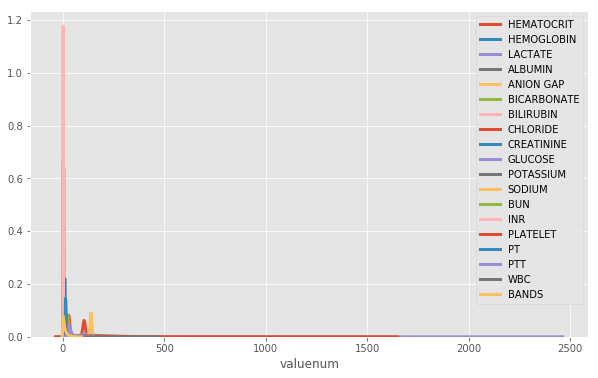

time: 33.4 s


In [201]:
#get the clinical variable
for var in labs_all48['label'].unique():
    subset = labs_all48[labs_all48['label']==var]
    sns.distplot(subset.loc[(subset['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
                 hist = False, 
                 kde = True, 
                 kde_kws = {'linewidth': 3},label = var)

plt.show()
    
#     plt.figure()
#     sns.countplot(subset)
# plt.legend(prop={'size': 16}, title = 'Lab Test')
# plt.title('Value num for tests in labs_all48')
# plt.xlabel('valuenum (units change)')
# plt.ylabel('Density')

    #sns.distplot(labs_all48[labs_all48['label']=='LACTATE']['charttime'].astype("datetime64").dt.month, hist = False, kde = True, kde_kws = {'linewidth': 3},label = var)
    


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: 'AxesSubplot' object is not callable

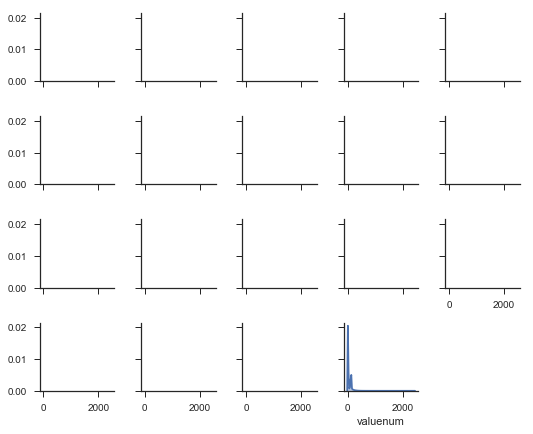

time: 10.7 s


In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Create a dataset with many short random walks
# rs = np.random.RandomState(4)
# pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
# pos -= pos[:, 0, np.newaxis]
# step = np.tile(range(5), 20)
# walk = np.repeat(range(20), 5)
# df = pd.DataFrame(np.c_[pos.flat, step, walk],
#                   columns=["position", "step", "walk"])


# for var in labs_all48['label'].unique():
#     subset = labs_all48[labs_all48['label']==var]
#     sns.distplot(subset.loc[(subset['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
#                  hist = False, 
#                  kde = True, 
#                  kde_kws = {'linewidth': 3},label = var)


lab_notnul= labs_all48[labs_all48['valuenum'].notnull()]

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(lab_notnul, col="label", #hue="walk",
                     col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.distplot(lab_notnul['valuenum']),hist = False, kde = True, kde_kws = {'linewidth': 3})
    
#    plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)

In [45]:
testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].unique()

array([1.9, 0.4, 0.3, 0.2, 0.9, 0.7, 1.7, 2.3, 5.9, 4.7, 0.8, 1. ])

time: 5.28 ms


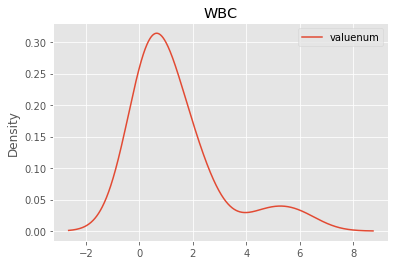

time: 160 ms


In [47]:
testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].plot(kind='kde',legend=True, title=title)

In [60]:
#testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].min() 
#hmm the kde is not approximating them very well


# sns.distplot(testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'], hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})


#df = pd.read_pickle('data.pkl')
#df.columns = ['timestamp', 'senderId']

import ggplot

plot = ggplot(aes(x = 'valuenum'), data= testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN',['valuenum','label']])
plot = plot + geom_density()
print(plot)

NameError: name 'aes' is not defined

time: 10.7 ms


In [65]:
import rpy2

time: 605 µs


In [67]:
make_r_df

Object `make_r_df` not found.
time: 2.34 ms


In [72]:

r_df = make_r_df(testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN',['valuenum','label']])
r.pdf("plot.pdf")

#a<- ggplot(labs_all48, aes(x=valuenum)) #+ geom_density()

#a + facet_wrap(~ label, scales = "free") + geom_density(aes(color = label)) 

p = ggplot2.ggplot(r_df, aes(x=valuenum)) + geom_density()
p.plot()

NameError: name 'make_r_df' is not defined

time: 148 ms


In [74]:
#using ggplot2 in jupyter
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic

import rpy2.ipython

%reload_ext rpy2.ipython

# We need ggplot2

%R require(ggplot2)
%R library("ggplot2")
# Load in the pandas library
import pandas as pd 
# Make a pandas DataFrame
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
# Take the name of input variable df and assign it to an R variable of the same name
%R -i df
# Plot the DataFrame df
#ggplot(data=df) + geom_point(aes(x=A, y=B, color=C))
%R print(ggplot(data=df) + geom_point(aes(x=A, y=B, color=C)))

AttributeError: 'NoneType' object has no attribute 'name'

time: 34.6 ms


NameError: name 'library' is not defined

time: 8.02 ms


In [58]:
ggplot?

time: 53.2 ms


Type:        module
String form: <module 'ggplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ggplot/__init__.py'>
File:        ~/anaconda/envs/rpy-env/lib/python3.6/site-packages/ggplot/__init__.py
Docstring:   <no docstring>


#Notice that a wider bandwidth results in more smoothing of the distribution. We also see that even though we limited our data to -60 to 120 minutes, the density plot extends beyond these limits. This is one potential issue with a density plot: because it calculates a distribution at each data point, it can generate data that falls outside the bounds of the original data. This might mean that we end up with impossible values on the x-axis that were never present in the original data! As a note, we can also change the kernel, which changes the distribution drawn at each data point and thus the overall distribution. However, for most applications, the default kernel, Gaussian, and the default bandwidth estimation work very well.

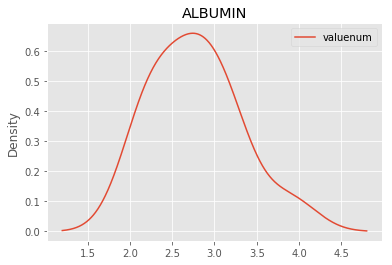

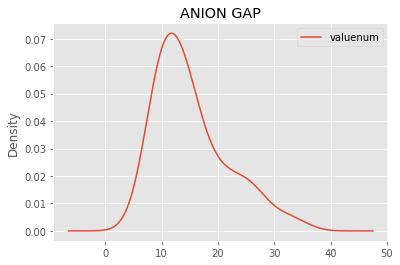

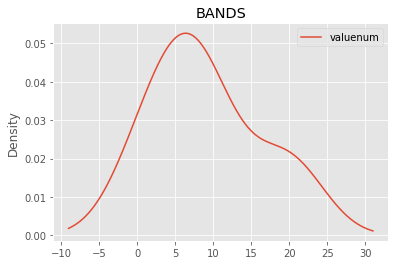

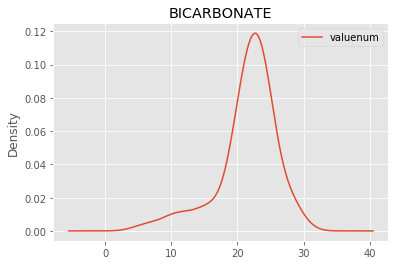

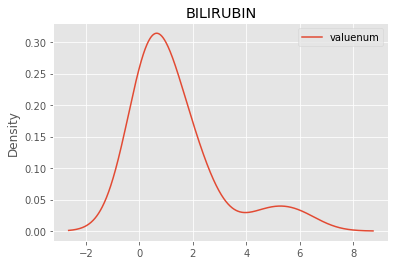

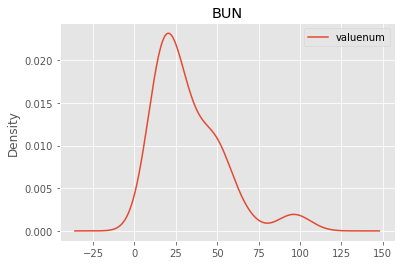

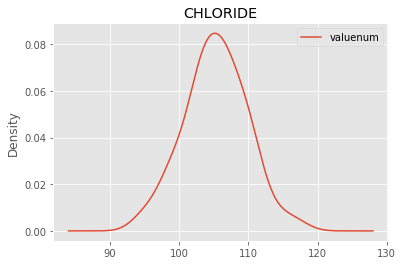

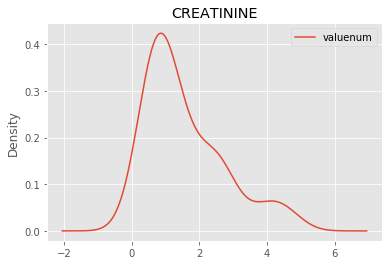

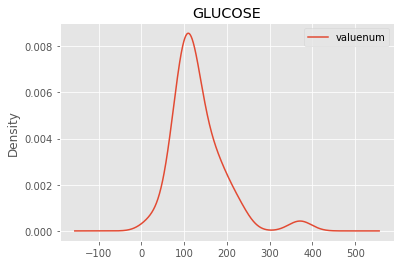

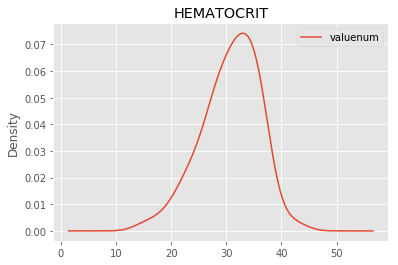

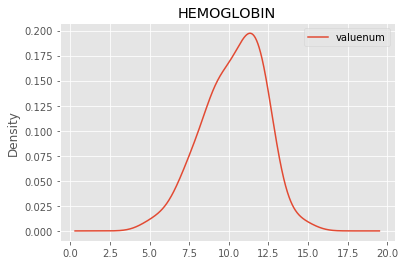

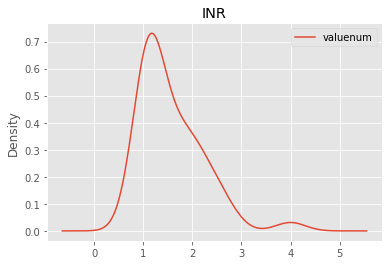

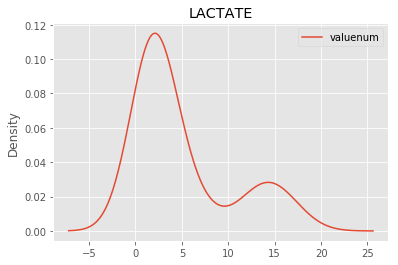

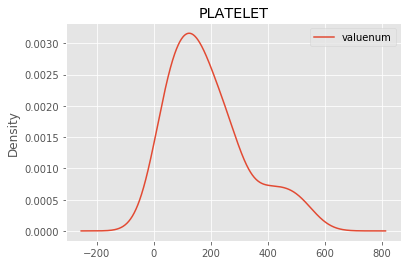

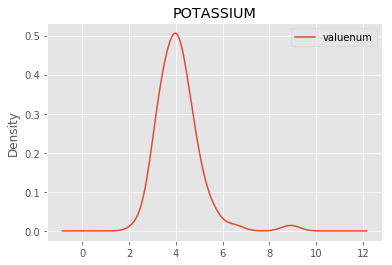

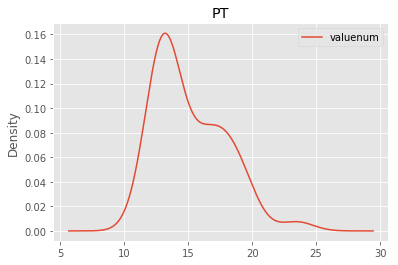

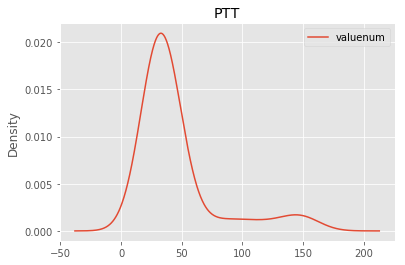

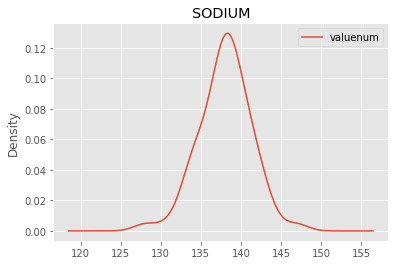

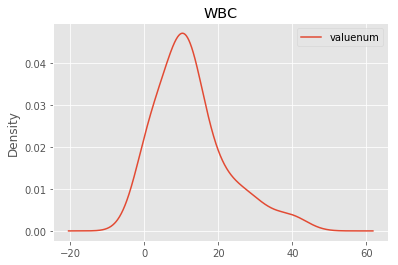

time: 2.9 s


In [37]:
testdf2= labs_all48.iloc[1:1000,:]
#testdf2.groupby('label')['valuenum'].plot(kind='density', legend=True)

for title, group in testdf2.groupby('label'):
    group[['valuenum','label']].plot(kind='density', legend=True, title=title)

In [18]:
testdf2[['label','valuenum','icustay_id']]

,label,valuenum,icustay_id
1,HEMOGLOBIN,10.5,294638
2,LACTATE,2.1,294638
3,ALBUMIN,2.8,294638
4,ANION GAP,15.0,294638
5,BICARBONATE,21.0,294638
6,BILIRUBIN,1.9,294638
7,CHLORIDE,108.0,294638
8,CREATININE,0.5,294638
9,GLUCOSE,183.0,294638
10,POTASSIUM,3.3,294638


time: 16.7 ms


In [ ]:
labs_all48.iloc[1:100,:]

In [8]:
labs_all48.iloc[1:100,:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
1,4,185777,294638,2191-03-15 21:23:00,HEMOGLOBIN,10.5
2,4,185777,294638,2191-03-15 21:23:00,LACTATE,2.1
3,4,185777,294638,2191-03-16 05:42:00,ALBUMIN,2.8
4,4,185777,294638,2191-03-16 05:42:00,ANION GAP,15.0
5,4,185777,294638,2191-03-16 05:42:00,BICARBONATE,21.0
6,4,185777,294638,2191-03-16 05:42:00,BILIRUBIN,1.9
7,4,185777,294638,2191-03-16 05:42:00,CHLORIDE,108.0
8,4,185777,294638,2191-03-16 05:42:00,CREATININE,0.5
9,4,185777,294638,2191-03-16 05:42:00,GLUCOSE,183.0
10,4,185777,294638,2191-03-16 05:42:00,POTASSIUM,3.3


time: 24.2 ms


Text(0,0.5,'Density')

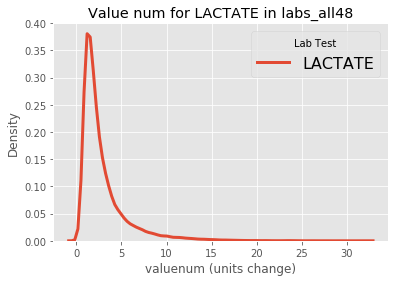

time: 440 ms


In [41]:
#first test that all plots for labels work:
#lactate  
#density plot
var='LACTATE'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

Text(0,0.5,'Density')

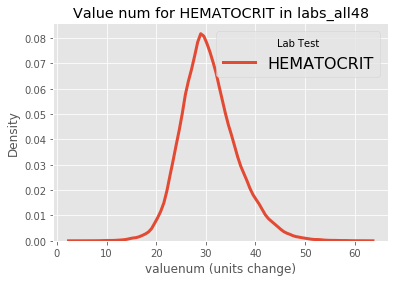

time: 529 ms


In [42]:
var='HEMATOCRIT'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [ ]:
var='HEMATOCRIT'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

#failed plotting stuff:
    still haven't figured out how to plot multiple graphs on the same line or in a grid that have different axes or without manual coding of them in subplots.
    #would be really nice to be able to just generate all density fxns for each label in 

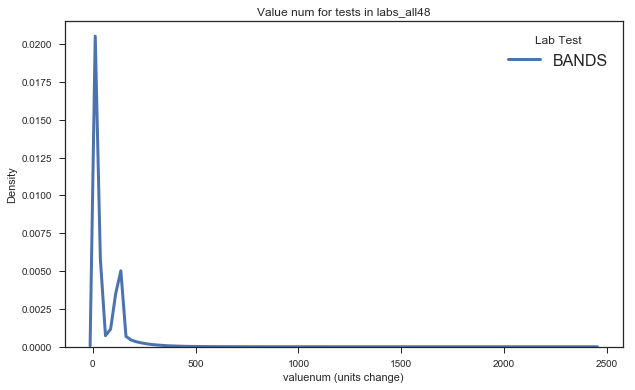

time: 7.05 s


In [208]:
sns.distplot(labs_all48.loc[(labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')
plt.show()

In [7]:
import seaborn as sns
g = sns.FacetGrid(labs_all48.loc[(labs_all48['valuenum'].notnull()),:].groupby('label)', col='label', col_wrap=3, palette="Set1")
g.map(sns.distplot, "valuenum", hist=False, rug=True)

SyntaxError: invalid syntax (<ipython-input-7-03d0d1a8bb5d>, line 3)

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


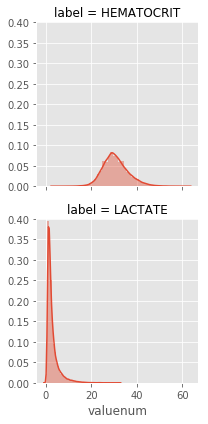

time: 983 ms


In [38]:
#pairgrid

testdf= labs_all48[(labs_all48['valuenum'].notnull()) & (labs_all48['label'].isin(['LACTATE','HEMATOCRIT']))][['label','valuenum','icustay_id']]

# g= sns.PairGrid(testdf, x_vars=['valuenum'], y_vars=['Density'],hue='label', size=4)
# g.map(sns.distplot, 'valuenum', color='0.3')


g=sns.FacetGrid(testdf, row='label')
g.map(sns.distplot, 'valuenum')#, hist=False, rug=True)
plt.show()

In [19]:
labs_all48[(labs_all48['valuenum'].notnull()) & (labs_all48['label'].isin(['LACTATE','HEMATOCRIT']))][['label','valuenum','icustay_id']]

,label,valuenum,icustay_id
0,HEMATOCRIT,32.0,294638
2,LACTATE,2.1,294638
13,HEMATOCRIT,31.8,294638
28,HEMATOCRIT,31.7,294638
43,HEMATOCRIT,36.5,273430
58,HEMATOCRIT,36.4,273430
62,LACTATE,1.2,273430
63,HEMATOCRIT,27.0,217847
82,HEMATOCRIT,33.4,217847
90,LACTATE,1.9,217847


time: 59.6 ms


Text(0,0.5,'Density')

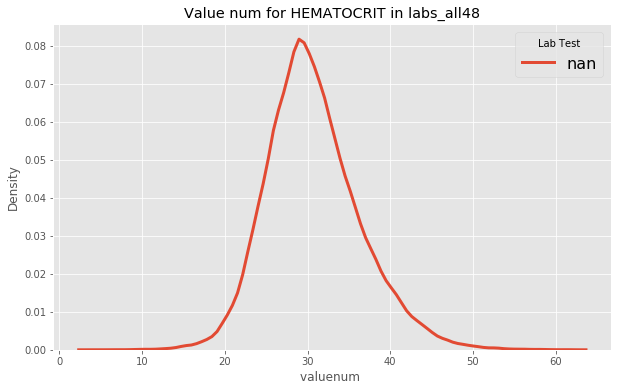

time: 670 ms


In [200]:
#HEMATOCRIT  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='HEMATOCRIT') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for HEMATOCRIT in labs_all48')
plt.xlabel('valuenum ')
plt.ylabel('Density')

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [191]:
#labs_all48[labs_all48['label']=='LACTATE']['charttime'].astype("datetime64").dt.month
#labs_all48[labs_all48['label']=='LACTATE']


#labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]
for var in labs_all48['label'].unique():
    print(var)


HEMATOCRIT
HEMOGLOBIN
LACTATE
ALBUMIN
ANION GAP
BICARBONATE
BILIRUBIN
CHLORIDE
CREATININE
GLUCOSE
POTASSIUM
SODIUM
BUN
INR
PLATELET
PT
PTT
WBC
BANDS
nan
time: 86.6 ms


In [197]:
labs_all48= labs_all48[labs_all48['label'].notnull()]

time: 118 ms


# code graveyard

In [ ]:
#broken code for plotting the datetimes

#vaso_df['starttime'].value_counts().sort_index().plot.bar(color = 'mediumvioletred', title = 'starttime historgram for vaso_df');

#--------#
# #pd.to_datetime(ABrx_16sterile_ntnul['startdate']

# # Define your own bins
# mybins = range(vaso_df['starttime_strf'].min(), vaso_df['starttime_strf'].max(), 10)

# # Cut the data with the help of the bins
# vaso_df['age_bucket'] = pd.cut(vaso_df['starttime_strf'], bins=mybins)

# # Count the number of values per bucket
# vaso_df['age_bucket'].value_counts()

#--------#
# #len(ABrx_ntnull['icustay_id'].unique())

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# test1['peroid'].sort_values(ascending=True).plot.hist(100)

#--------#

# import pandas as pd
# vaso_df['starttime_dt']=pd.to_datetime(vaso_df['starttime'])
# vaso_df['starttime_strf']= vaso_df['starttime_dt'].dt.strftime('%Y-%m-%d')

#--------#
#trying to get starttime to peroids by month
#from datetime import datetime
#import numpy as np
#from pandas.tseries.offsets import BDay
#test1=pd.to_datetime(vaso_df.starttime)
# test1=vaso_df
# dates= pd.DatetimeIndex(test1['starttime'])
# test1['peroid']=dates.to_period('M')


In [5]:
"""
    get the # of filled vs missign values for each variable for our cohort.
    Args:
    -----
    df: dataframe
        name of dataframe initialized in this workbook
    valuenum_col: string
        name of column with the numerical or text variable in question
    label_col: string
        name of column with the lab value label in question
    Returns:
    -----
    filled_summary: df
        list of all variables with # filled values
    missing_summary: df
        list of all variables with # missing values
    percent_summary: df
        list of all variables with # filled values/ # total patients
    """

def missing_fxn(df, valuenum_col, label_col):
    if 'icustay_id' in list(df):
        df= df[df['icustay_id'].isin(list(cohort_df['icustay_id'].unique()))] #good
    else:
        df= df[df['subject_id'].isin(
            list(cohort_df['subject_id'].unique()))] 

    df_notnull = df[df[valuenum_col].notnull()]
    df_null = df[df[valuenum_col].isnull()]
    df_filtered = df.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    
    filled_summary= df_notnull.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    missing_summary = df_null.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    percent_summary = 100*(filled_summary / df_filtered)
    
    #missing_plot=(missing_summary.sort_index().plot.bar(title = f'# of missing values in {df}'))
    
    #filled_summary, missing_summary, percent_summary, 
    return(filled_summary, missing_summary, percent_summary)

time: 22.7 ms


In [ ]:
#labs
var1, var2, var3,  = missing_fxn(labs_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in labs_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

In [136]:
list(final_pt_df2.columns)

['subject_id',
 'icustay_id',
 'hadm_id',
 't_0_sc',
 't_end_sc',
 'ab_course',
 't_0',
 't_end_consec',
 'dod_hosp',
 'dod_ssn',
 'dod_delta',
 'org_list',
 'spec_type_list',
 'sc_result',
 'final_bin']

time: 35.2 ms


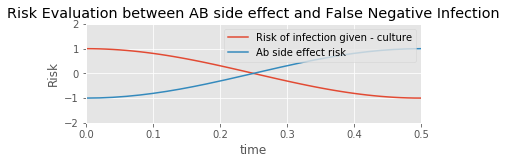

time: 318 ms


In [2]:
from matplotlib.pyplot import figure, show
from numpy import arange, sin, cos,tan, pi

t = arange(0.0, 1.0, 0.01)
z = arange(0.0, 2.0, 0.01)
fig = figure(1)

ax1 = fig.add_subplot(211)
ax1.plot(t, cos(2*pi*t))
ax1.plot(z, -cos(2*pi*z))
ax1.grid(True)
ax1.set_ylim((-2, 2))
ax1.set_xlim((0, 0.5))
ax1.set_ylabel('Risk')
ax1.set_xlabel('time')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')

ax1.legend(('Risk of infection given - culture', 'Ab side effect risk',), loc= 'upper right')



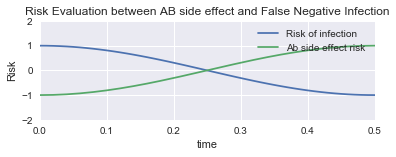

time: 151 ms


In [6]:
from matplotlib.pyplot import figure, show
from numpy import arange, sin, cos,tan, pi

t = arange(0.0, 1.0, 0.01)
z = arange(0.0, 2.0, 0.01)
fig = figure(1)

ax1 = fig.add_subplot(211)
ax1.plot(t, cos(2*pi*t))
ax1.plot(z, -cos(2*pi*z))
ax1.grid(True)
ax1.set_ylim((-2, 2))
ax1.set_xlim((0, 0.5))
ax1.set_ylabel('Risk')
ax1.set_xlabel('time')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')

ax1.legend(('Risk of infection', 'Ab side effect risk',), loc= 'upper right')



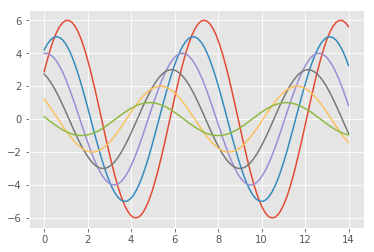

time: 164 ms


In [4]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)

sinplot()

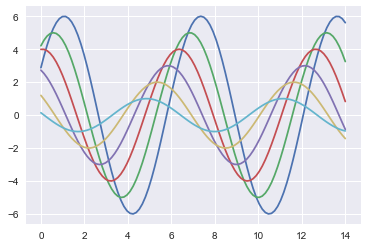

time: 128 ms


In [5]:
sns.set()
sinplot()

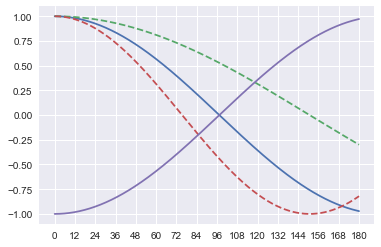

time: 156 ms


In [43]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 180, 1000)
ax.plot(x, np.cos((1/62)*x), linestyle='-')
ax.plot(x, np.cos((1/96)*x), linestyle='--')
ax.plot(x, np.cos((1/48)*x), linestyle='--')
ax.plot(x, -np.cos((1/62)*x), linestyle='-')
plt.xticks(np.arange(min(x), max(x)+1, 12));

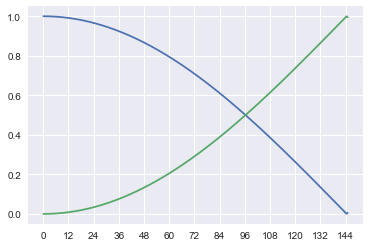

time: 123 ms


In [56]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 145, 1000)
ax.plot(x, abs(np.cos((1/92)*x)), linestyle='-')
ax.plot(x, 1+ -abs(np.cos((1/92)*x)), linestyle='-')
plt.xticks(np.arange(min(x), max(x)+1, 12));

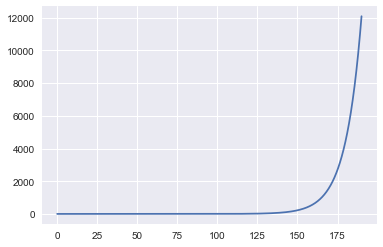

time: 125 ms


In [107]:
from scipy.special import expit
from numpy import exp

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 190, 1000)
xt=96
k=0.1
ax.plot(x, (1/(np.exp(-k*(x-xt)))))

<Figure size 432x288 with 0 Axes>

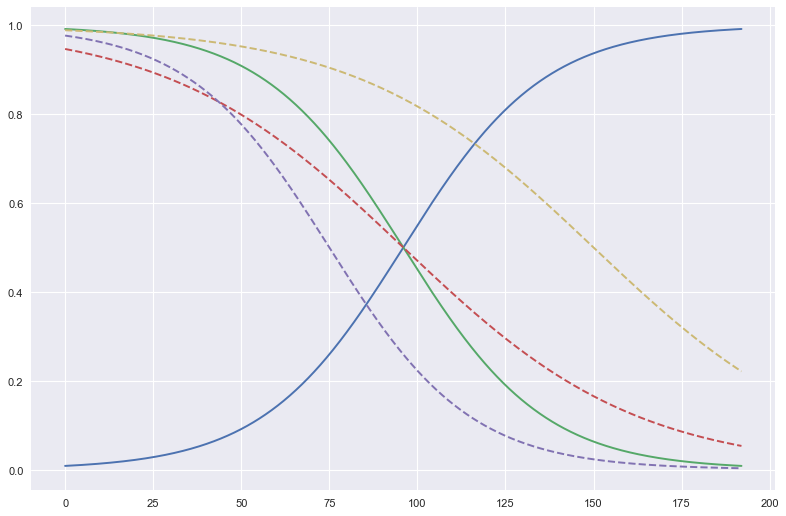

time: 197 ms


In [151]:
from scipy.special import expit
from numpy import exp

fig = plt.figure()
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w')
ax = plt.axes()

x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.05 #slope of the curve
L=1 # max y value
ax.plot(x, (L/(1+exp(-k*(x-xt)))), linestyle='-')
ax.plot(x, 1-(L/(1+exp(-k*(x-xt)))), linestyle='-')
ax.plot(x, 1-(L/(1+exp(-0.03*(x-xt)))), linestyle='--')
ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
ax.plot(x, 1-(L/(1+exp(-0.03*(x-150)))), linestyle='--')


 
 So, essentially, at the beginning, with little information, risk for infection is high (patient is sick in the ICU, infections are common) then as more clinical information is available, for those with no infection we hypothesize that we will be able to detect a decrease in probability of infection using that data (our central hypothesis).


<Figure size 432x288 with 0 Axes>

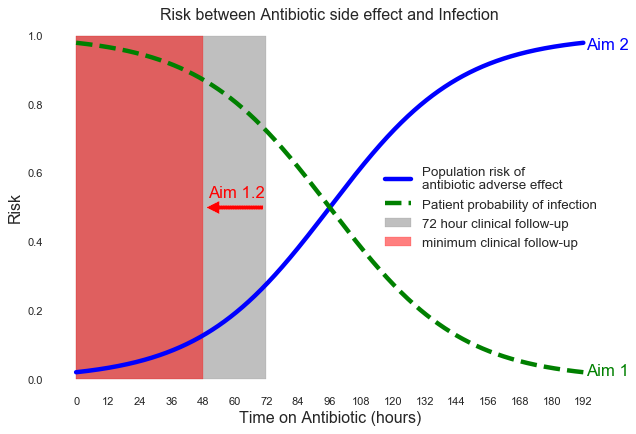

time: 431 ms


In [299]:
from scipy.special import expit
from numpy import exp
import matplotlib.patches as patches

fig = plt.figure()
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='green'
       )

#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot(x, 1-(L/(1+exp(-0.03*(x-150)))), linestyle='--')
#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot([72, 72], [0, 1], color='black', linestyle=':', linewidth=2) #og clinical time
#ax.plot([48, 48], [0, 1], color='red', linestyle=':', linewidth=2) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72-24, 0.5),
            xytext=(92-20, 0.5),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(183, 0.01),
            xytext=(193, 0.01),
            color='green',
            size=15
            )
# ax.annotate('Aim 1.2',
#             xy=(62, 0.49),
#             xytext=(72, 0.49),
#             color='red',
#             size=15,
#             )
ax.annotate('Aim 1.2',
            xy=(40, 0.53),
            xytext=(50, 0.53),
            color='red',
            size=15,
            )

ax.annotate('Aim 2',
            xy=(183, 0.96),
            xytext=(193, 0.96),
            color='blue',
            size=15,
            )

###rectangles
p = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p) #adds grey rectangle
p = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p)

###legend
ax.legend((
    'Population risk of \nantibiotic adverse effect',
    'Patient probability of infection',
    '72 hour clinical follow-up',
    'minimum clinical follow-up'),
    loc= 'best', fontsize='medium')
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk', fontsize='large')
ax.set_xlabel('Time on Antibiotic (hours)', fontsize='large')
ax.set_title('Risk between Antibiotic side effect and Infection', fontsize='large')
plt.xticks(np.arange(min(x), max(x)+1, 12))




print("\n \n So, essentially, at the beginning, with little information, risk for infection is high (patient is sick in the ICU, infections are common) then as more clinical information is available, for those with no infection we hypothesize that we will be able to detect a decrease in probability of infection using that data (our central hypothesis).")
